In [2]:
# Для Google Collab
if 1:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


импорт библиотек

In [3]:
if 1:
    !pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.2 MB/s 


In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client, wait
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D
import pylab
from scipy import stats
import random
# Кластеризация
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
# Понижения размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#from auxiliary import trim_memory
#from telecom.transformers import ColumnsCorrector
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score,\
                learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.feature_selection import RFE
#from lightgbm import LGBMClassifier
import catboost as catb
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

/home/jb/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
if 1:
    !pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.6 MB/s 


In [6]:
import shap

# load JS visualization code to notebook
shap.initjs()

# Поскольку работал в Гугл Коллабе в разных аккаунтах, используемые функции пришлось оставить в ноутбуке, а не выносить в отдельный файл

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
    
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [3]:
def choise_features(train, test, cat_feats):
    """Функция для проверки метрик и выбора признаков, cat_feats для категориальных признаков"""
    X_train = train.drop(columns=['target'])
    y_train = train['target']
    X_test = test.drop(columns=['target'])
    y_test = test['target']

    display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))
    disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
    frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features': cat_feats,
     'eval_metric':'TotalF1',
     'early_stopping_rounds':40
    }    

    model_catb = catb.CatBoostClassifier(**frozen_params, iterations=300, max_depth=5)
    model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))
    evaluate_preds(model_catb, X_train, X_test, y_train, y_test)
    feature_importances = pd.DataFrame(zip(X_train.columns, model_catb.feature_importances_), 
                                       columns=['feature_name', 'importance'])
    feature_importances.sort_values(by='importance', ascending=False)

    return feature_importances

In [4]:
def reduce_mem_usage(df):
    import numpy as np
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2 # подсчитываем память потребляемую изначальным           #датасетом
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns: # проходимся по всем колонкам
        col_type = df[col].dtype  # узнаем тип колонки
        
        if col_type != object:
            c_min = df[col].min() # смотрим минимальное значение признака
            c_max = df[col].max() # смотрим максимальное значение признака
            if str(col_type)[:3] == 'int':  # if int
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: # сравниваем с          #int8
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: # сравниваем с      #int16 и.т.д.
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else: # если был тип object, то меняем его тип на пандасовский тип 'category', на нем разные       #агрегации данных работают в разы быстрее
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2  # считаем сколько теперь у нас занято памяти
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))  # и выводим статистику
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
def plot_hist(x, title="", xlabel=""):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Количество")
    plt.hist(x, bins=30)
    plt.show()

In [10]:
if 1:
    cwd = pathlib.Path().cwd()
    sys.path.append(cwd.as_posix())
    data_folder = cwd.joinpath('data')
    model_folder = cwd.joinpath('models')

## Загрузка предварительно обработанного датасета

In [13]:
if 0:
    df_all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_MEGAFON_CW/merged_train.csv')

In [14]:
if 1:
    df_all = pd.read_csv(data_folder.joinpath('merged_train.csv'))

In [15]:
df_all.head()

Unnamed: 0       id  vas_id  buy_time_train  target      buy_time  \
0          23  3532789     1.0      1531083600     0.0  1.531084e+09   
1         101   167964     4.0      1531083600     0.0  1.531084e+09   
2         151  4236220     1.0      1531083600     0.0  1.531084e+09   
3         192  3883492     4.0      1531083600     0.0  1.531084e+09   
4         250  2847225     1.0      1531083600     0.0  1.531084e+09   

            0           1           2           3  ...          244  \
0  -30.349971 -139.569112  -44.290786 -192.176798  ...  -613.770792   
1  280.330029   47.670888  266.389214   -4.936798  ...  -613.770792   
2  -96.799971   49.440888 -110.740786   -3.166798  ...  -539.770792   
3  -92.139971  -46.319112 -106.080786   61.243202  ...  -613.770792   
4  464.210029  428.250888  450.269214  375.643202  ...  6258.229208   

         245        246          247        248       249        250      251  \
0 -25.996269 -37.630448  -306.747724 -25.832889 -0.694428 -12.175933 -0.45614   
1 -25.996269 -37.630448  -237.747724 -20.832889 -0.694428  -7.175933 -0.45614   
2 -25.996269 -37.630448  -290.747724 -25.832889 -0.694428 -12.175933 -0.45614   
3 -24.996269 -37.630448  1699.252276 -20.832889  1.305572  -9.175933 -0.45614   
4 -18.996269  58.369552     1.252276 -25.832889 -0.694428 -12.175933 -0.45614   

   252  time_delta  
0  0.0         0.0  
1  0.0         0.0  
2  1.0         0.0  
3  1.0         0.0  
4  0.0         0.0  

[5 rows x 255 columns]

In [16]:
df_all = df_all.drop(columns=['Unnamed: 0'])

In [17]:
df_all = reduce_mem_usage(df_all)

Memory usage of dataframe is 792.05 MB
Memory usage after optimization is: 396.03 MB
Decreased by 50.0%


Проверил какой энкодер дает лучшую метрику. Почти все одинаковую. Скорее всего это говорит о том, что категориальные признаки не имеют высокую важность. Перетянул этот код наверх, чтобы показать логику принятия решения. И принял решение чтобы сэкономить время категориальные признаки не исследовать.


In [70]:
y = df_all['target']
X = df_all.drop(['target'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)
train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

# Сжатие нумерованных признаков

In [71]:
class My_pca:

    def __init__(self, cat_feats):
        self.cat_feats = cat_feats
        self.scaler = None
        self.corr_feats = None
        self.not_corr_feats = ['target', 'id', 'buy_time_train', 'vas_id', 'time_delta']
        self.dim_reducer3d = None


    def convert_to_int(self, df):
        df=df.copy()
        df[self.cat_feats] = df[self.cat_feats].astype('int8')
        
        return df

    def my_scaler_fit(self, df):
        """Обучаю RobustScaler для стандартизации нумерованных фичей для   упаковки в  PCA"""
        from sklearn.preprocessing import RobustScaler
        self.scaler = RobustScaler()
        self.scaler.fit(df[self.corr_feats])
    
        #return self.scaler

    def my_scaler_transform(self, df):
        """Преобразую RobustScaler_ом нумерованные фичи для упаковки в  PCA и показываю корреляцию этих фичей"""
        df=df.copy()
        df_norm = self.scaler.fit_transform(df[self.corr_feats])
    
        plt.figure(figsize = (15,10))
        sns.set(font_scale=1.4)
        corr_matrix = pd.DataFrame(df_norm).corr()
        corr_matrix = np.round(corr_matrix, 2)  # округлим до 2 знаков
        corr_matrix[np.abs(corr_matrix) < 0.5] = 0  # если корреляция меньше 0,5, то мы заменим на 0
        sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
        plt.title('Correlation matrix')
        plt.show()
    
        df_1 = df[self.not_corr_feats]
        df_1 = df_1.reset_index(drop=True)
        df_norm = pd.DataFrame(df_norm, columns = self.corr_feats)
        df_scaled=pd.concat([df_1, df_norm], axis=1)
    
        return df_scaled

    def reduce_dims(self, df, dims=2, method='pca', perplexity=30):
    
        assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
        if method=='pca':
            from sklearn.decomposition import PCA
            dim_reducer = PCA(n_components=dims, random_state=42)
            components = dim_reducer.fit_transform(df)
        elif method == 'tsne':
            dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42, perplexity=perplexity)
            components = dim_reducer.fit_transform(df)
        else:
            print('Error')
        
        colnames = ['component_' + str(i) for i in range(1, dims+1)]
        return dim_reducer, pd.DataFrame(data = components, columns = colnames) 

    def pca_fit_transform(self, train):
        """Функция сжимающая малозначимые признаки методом PCA и возвращающая кроме 
        обработанного датасета натренированную модель PCA"""
        train=train.copy()
        self.dim_reducer3d, components_3d = self.reduce_dims(train[self.corr_feats], 
                                                             dims=3, method='pca')
        train_pca = pd.concat([train[self.not_corr_feats], components_3d], axis=1)
    
        return train_pca

    def pca_transform(self, test):
        """Функция сжимающая малозначимые признаки методом PCA на тестовой выборке"""
        test=test.copy()
        dims = 3
        components = self.dim_reducer3d.transform(test[self.corr_feats])
        colnames = ['component_' + str(i) for i in range(1, dims+1)]
        components_3d_test = pd.DataFrame(data = components, columns = colnames)
        test_pca = pd.concat([test[self.not_corr_feats],
                              components_3d_test], axis=1)
    
        return test_pca


    def fit_transform(self, train):
        train=train.copy()
        train = self.convert_to_int(train)
        all_feats = train.columns.tolist()
        self.corr_feats = [i for i in all_feats if i not in self.not_corr_feats]
        self.my_scaler_fit(train)
        train = self.my_scaler_transform(train)
        train_pca = self.pca_fit_transform(train)
        return train_pca

    def transform(self, test):
        test=test.copy()
        test = self.convert_to_int(test)
        test = self.my_scaler_transform(test)
        test_pca = self.pca_transform(test)      
        return test_pca

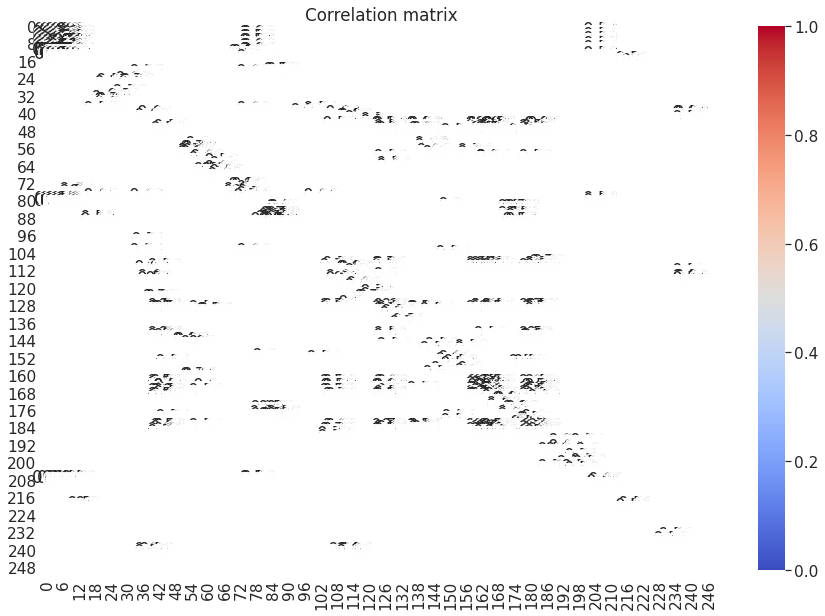

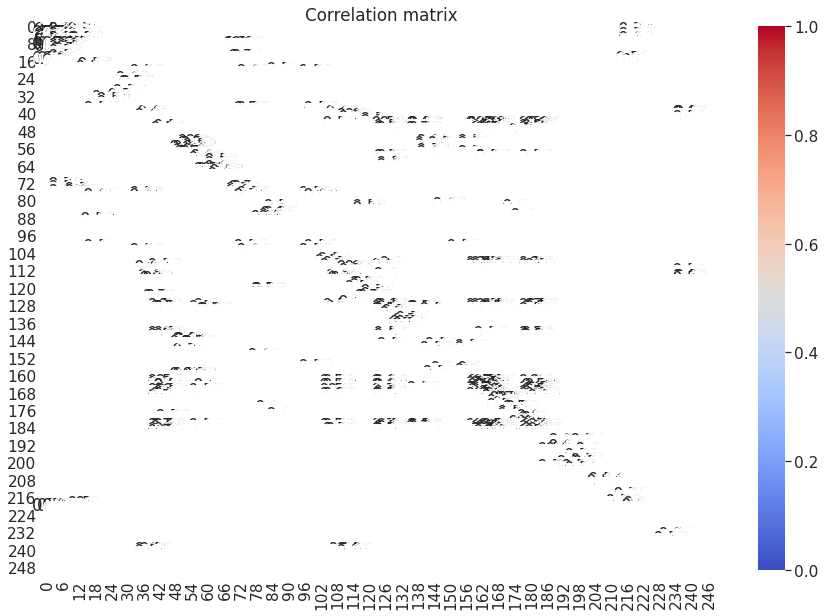

In [72]:
step_2 = My_pca(['vas_id'])

train = step_2.fit_transform(train)
test = step_2.transform(test)

In [73]:
test.head()

target       id  buy_time_train  vas_id  time_delta  component_1  \
0     1.0   718465      1535317200       2   2419200.0 -126710296.0   
1     0.0  2342608      1544994000       4   6652800.0 -126710296.0   
2     0.0  3807550      1538341200       4   1209600.0 -126710296.0   
3     0.0  1830223      1544994000       5   1814400.0 -126710296.0   
4     0.0  3072174      1545598800       1   6652800.0 -126710296.0   

    component_2  component_3  
0 -88900.007812 -5003.981445  
1 -88900.007812 -5003.981445  
2 -88900.007812 -5003.981445  
3 -88900.007812 -5003.981445  
4 -88900.007812 -5003.981445

component_1
MannwhitneyuResult(statistic=2893883488.5, pvalue=0.0)


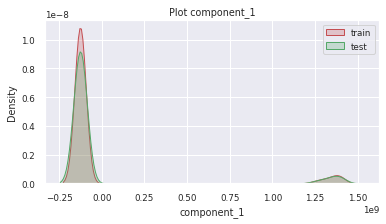

component_2
MannwhitneyuResult(statistic=9211287987.0, pvalue=0.0)


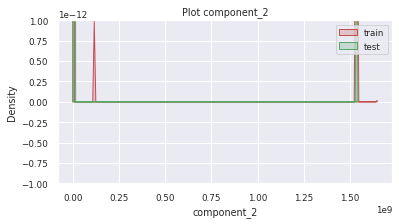

component_3
MannwhitneyuResult(statistic=25981533416.5, pvalue=0.0)


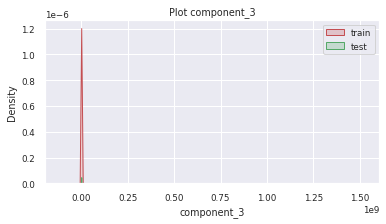

In [74]:
#Проверка соответствия признаков на трейне и на тесте

figsize = (6, 3)
for col in ['component_1', 'component_2', 'component_3']:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(train[col], shade = True, label='train', color = 'r')
    sns.kdeplot(test[col], shade = True, label='test', color = 'g')
    print(col)
    print(stats.mannwhitneyu(train[col], test[col]))
    plt.legend()
    plt.title(f"Plot {col}")
    plt.show()

component_2 придется удалить.

In [75]:
def display_components_in_3D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    if labels is not None:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   c=components_with_labels_df.iloc[:, -1], 
                   cmap=plt.get_cmap('jet'), alpha=0.5)
    else:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   alpha=0.5)

    ax.set_xlabel('component_1')
    ax.set_ylabel('component_2')
    ax.set_zlabel('component_3')
    plt.title('3D mapping of objects')
    plt.show()

In [76]:
components_df = train[['component_1', 'component_2', 'component_3']]

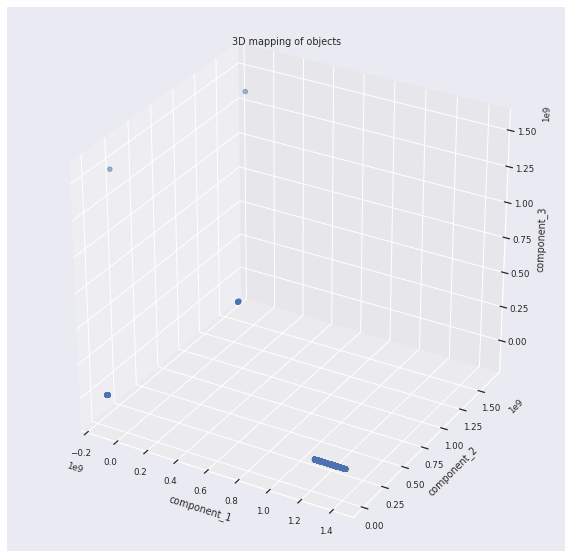

In [78]:
display_components_in_3D_space(components_df)

# Кластеризация

In [79]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8, random_state=0).fit(components_df)
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [80]:
len(kmeans.labels_)

286106

In [81]:
train['clasters'] = kmeans.labels_

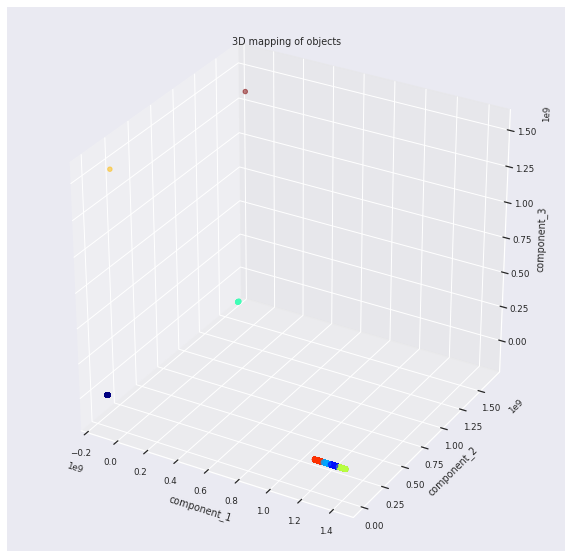

In [82]:
display_components_in_3D_space(components_df, kmeans.labels_)

Kmeans  справился.

In [83]:
test_components_df = test[['component_1', 'component_2', 'component_3']]

In [84]:
len(kmeans.predict(test_components_df))

122618

In [85]:
test.shape

(122618, 8)

In [86]:
test['clasters'] = kmeans.predict(test_components_df)

Оставил код на будущее для других методов кластеризации

In [47]:
if 0:
    !pip install fuzzy-c-means

In [46]:
def apply_elbow_method_cmeans(X):
    """Визуализация для метода 'локтя'"""
    from fcmeans import FCM
    
    distortions = []
    K = range(3,10)
    for k in K:
        fcm = FCM(n_clusters=k)
        fcm.fit(X.to_numpy())
        #fcm = FCM(n_clusters=k).fit(X.to_numpy())
        distortions.append(sum(np.min(cdist(X.to_numpy(), fcm.centers, 'euclidean'), 
                                      axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [48]:
if 0:
    apply_elbow_method_cmeans(components_df)

In [49]:
if 0:
    from fcmeans import FCM
    fcm = FCM(n_clusters=6)
    fcm.fit(components_df.to_numpy())

In [50]:
if 0:
    fcm_centers = fcm.centers
    fcm_labels = fcm.predict(components_df.to_numpy())

In [51]:
#fcm_centers

In [52]:
#len(fcm_labels)

In [53]:
#display_components_in_3D_space(components_df, fcm_labels)

За 4 часа работы  DBSCAN так ничему не научился. Пришлось прервать выполнение прогаммы.

In [54]:
if 0:
    from sklearn.cluster import DBSCAN
    dbscan = DBSCAN(eps=1, min_samples=5).fit(components_df)
    dbscan.labels_


In [55]:
#display_components_in_3D_space(components_df, dbscan.labels_)

In [56]:
#train['clasters'] = clustering.labels_

In [57]:
import scipy
def dbscan_predict(dbscan_model, X_new, metric=scipy.spatial.distance.cosine):
# def dbscan_predict(dbscan_model, X_new, metric=sp.spatial.distance. euclidean):

    """https://stackoverflow.com/questions/27822752/scikit-learn-predicting-new-points-with-dbscan"""
    # Result is noise by default
    y_new = np.ones(shape=len(X_new), dtype=int)*-1 

    # Iterate all input samples for a label
    for j, x_new in enumerate(X_new):
        # Find a core sample closer than EPS
        for i, x_core in enumerate(dbscan_model.components_): 
            if metric(x_new, x_core) < dbscan_model.eps:
                # Assign label of x_core to x_new
                y_new[j] = dbscan_model.labels_[dbscan_model.core_sample_indices_[i]]
                break
    return y_new


In [58]:
if 0:
    # AgglomerativeClustering потребовал очень много ОЗУ
    from sklearn.cluster import AgglomerativeClustering
    agg_cl = AgglomerativeClustering(n_clusters=5).fit(components_df)
    agg_cl.labels_

In [59]:
#display_components_in_3D_space(train, agg_cl.labels_)

In [87]:
# в EDA признак был забракован
def drop_component_2(df):
    df.drop(columns=['component_2'], inplace=True)
    return df

train = drop_component_2(train)
test = drop_component_2(test)

# Проверка метрик для разных кластеров

In [88]:
fea_imp = choise_features(train, test, ['vas_id'])

0.0    0.90925
1.0    0.09075
Name: target, dtype: float64

0.0    0.909255
1.0    0.090745
Name: target, dtype: float64

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    260142
         1.0       0.40      0.95      0.56     25964

    accuracy                           0.87    286106
   macro avg       0.70      0.90      0.74    286106
weighted avg       0.94      0.87      0.89    286106

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    111491
         1.0       0.39      0.94      0.56     11127

    accuracy                           0.86    122618
   macro avg       0.69      0.90      0.74    122618
weighted avg       0.94      0.86      0.89    122618

CONFUSION MATRIX

col_0     0.0    1.0
target              
0.0     95451  16040
1.0       662  10465


In [89]:
fea_imp = choise_features(train.drop(columns=['clasters']), test.drop(columns=['clasters']), ['vas_id'])

0.0    0.90925
1.0    0.09075
Name: target, dtype: float64

0.0    0.909255
1.0    0.090745
Name: target, dtype: float64

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    260142
         1.0       0.40      0.95      0.56     25964

    accuracy                           0.87    286106
   macro avg       0.70      0.90      0.74    286106
weighted avg       0.94      0.87      0.89    286106

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    111491
         1.0       0.39      0.94      0.56     11127

    accuracy                           0.86    122618
   macro avg       0.69      0.90      0.74    122618
weighted avg       0.94      0.86      0.89    122618

CONFUSION MATRIX

col_0     0.0    1.0
target              
0.0     95438  16053
1.0       661  10466


In [90]:
train.clasters.unique()

array([0, 4, 1, 6, 2, 3, 7, 5], dtype=int32)

In [91]:
fea_imp = choise_features(train.loc[train['clasters']==0], test.loc[test['clasters']==0], ['vas_id'])

0.0    0.909529
1.0    0.090471
Name: target, dtype: float64

0.0    0.909354
1.0    0.090646
Name: target, dtype: float64

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    237830
         1.0       0.40      0.95      0.56     23657

    accuracy                           0.86    261487
   macro avg       0.70      0.90      0.74    261487
weighted avg       0.94      0.86      0.89    261487

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    101945
         1.0       0.40      0.94      0.56     10162

    accuracy                           0.87    112107
   macro avg       0.69      0.90      0.74    112107
weighted avg       0.94      0.87      0.89    112107

CONFUSION MATRIX

col_0     0.0    1.0
target              
0.0     87431  14514
1.0       620   9542


In [92]:
fea_imp = choise_features(train.loc[train['clasters']==1], test.loc[test['clasters']==1], ['vas_id'])

0.0    0.903867
1.0    0.096133
Name: target, dtype: float64

0.0    0.907919
1.0    0.092081
Name: target, dtype: float64

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91      5867
         1.0       0.39      0.94      0.55       624

    accuracy                           0.85      6491
   macro avg       0.69      0.89      0.73      6491
weighted avg       0.93      0.85      0.88      6491

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.85      0.92      2465
         1.0       0.39      0.90      0.54       250

    accuracy                           0.86      2715
   macro avg       0.69      0.88      0.73      2715
weighted avg       0.93      0.86      0.88      2715

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     2106  359
1.0       25  225


In [93]:
fea_imp = choise_features(train.loc[train['clasters']==2], test.loc[test['clasters']==2], ['vas_id'])

0.0    0.913815
1.0    0.086185
Name: target, dtype: float64

0.0    0.905294
1.0    0.094706
Name: target, dtype: float64

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.85      0.92      4379
         1.0       0.38      0.95      0.55       413

    accuracy                           0.86      4792
   macro avg       0.69      0.90      0.73      4792
weighted avg       0.94      0.86      0.89      4792

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92      1864
         1.0       0.41      0.94      0.58       195

    accuracy                           0.87      2059
   macro avg       0.70      0.90      0.75      2059
weighted avg       0.94      0.87      0.89      2059

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     1604  260
1.0       11  184


In [94]:
fea_imp = choise_features(train.loc[train['clasters']==3], test.loc[test['clasters']==3], ['vas_id'])

0.0    0.785714
1.0    0.214286
Name: target, dtype: float64

0.0    0.833333
1.0    0.166667
Name: target, dtype: float64

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95        11
         1.0       0.75      1.00      0.86         3

    accuracy                           0.93        14
   macro avg       0.88      0.95      0.90        14
weighted avg       0.95      0.93      0.93        14

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.60      0.75         5
         1.0       0.33      1.00      0.50         1

    accuracy                           0.67         6
   macro avg       0.67      0.80      0.62         6
weighted avg       0.89      0.67      0.71         6

CONFUSION MATRIX

col_0   0.0  1.0
target          
0.0       3    2
1.0       0    1


In [95]:
fea_imp = choise_features(train.loc[train['clasters']==4], test.loc[test['clasters']==4], ['vas_id'])

0.0    0.905836
1.0    0.094164
Name: target, dtype: float64

0.0    0.909859
1.0    0.090141
Name: target, dtype: float64

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.85      0.92      9639
         1.0       0.40      0.93      0.56      1002

    accuracy                           0.86     10641
   macro avg       0.69      0.89      0.74     10641
weighted avg       0.94      0.86      0.88     10641

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92      4199
         1.0       0.39      0.97      0.55       416

    accuracy                           0.86      4615
   macro avg       0.69      0.91      0.73      4615
weighted avg       0.94      0.86      0.88      4615

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     3559  640
1.0       14  402


In [100]:
train.loc[train['clasters']==5]

target       id  buy_time_train  vas_id  time_delta  component_1  \
116828     0.0  3889142      1546203600       2   5443200.0 -126722840.0   

         component_3  clasters  
116828  1.522282e+09         5

In [97]:
fea_imp = choise_features(train.loc[train['clasters']==6], test.loc[test['clasters']==6], ['vas_id'])

0.0    0.901082
1.0    0.098918
Name: target, dtype: float64

0.0    0.907706
1.0    0.092294
Name: target, dtype: float64

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92      2414
         1.0       0.42      0.95      0.58       265

    accuracy                           0.87      2679
   macro avg       0.71      0.90      0.75      2679
weighted avg       0.94      0.87      0.89      2679

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93      1013
         1.0       0.43      0.94      0.59       103

    accuracy                           0.88      1116
   macro avg       0.71      0.91      0.76      1116
weighted avg       0.94      0.88      0.90      1116

CONFUSION MATRIX

col_0   0.0  1.0
target          
0.0     884  129
1.0       6   97


In [101]:
train.loc[train['clasters']==7]

target      id  buy_time_train  vas_id  time_delta  component_1  \
71993     0.0  154748      1544994000       2   1209600.0 -126813688.0   

        component_3  clasters  
71993  1.377343e+09         7

Метрика повысилась всего на 1000 наблюдениях. Овчинка не стоит выделки.

Метрика c clasters не улучшилась.

In [102]:
train.drop(columns=['clasters'], inplace=True)
test.drop(columns=['clasters'], inplace=True)

In [105]:
if 1:
    train.to_csv('train.csv', index=False)
    test.to_csv('test.csv', index=False)

# Выделение дат

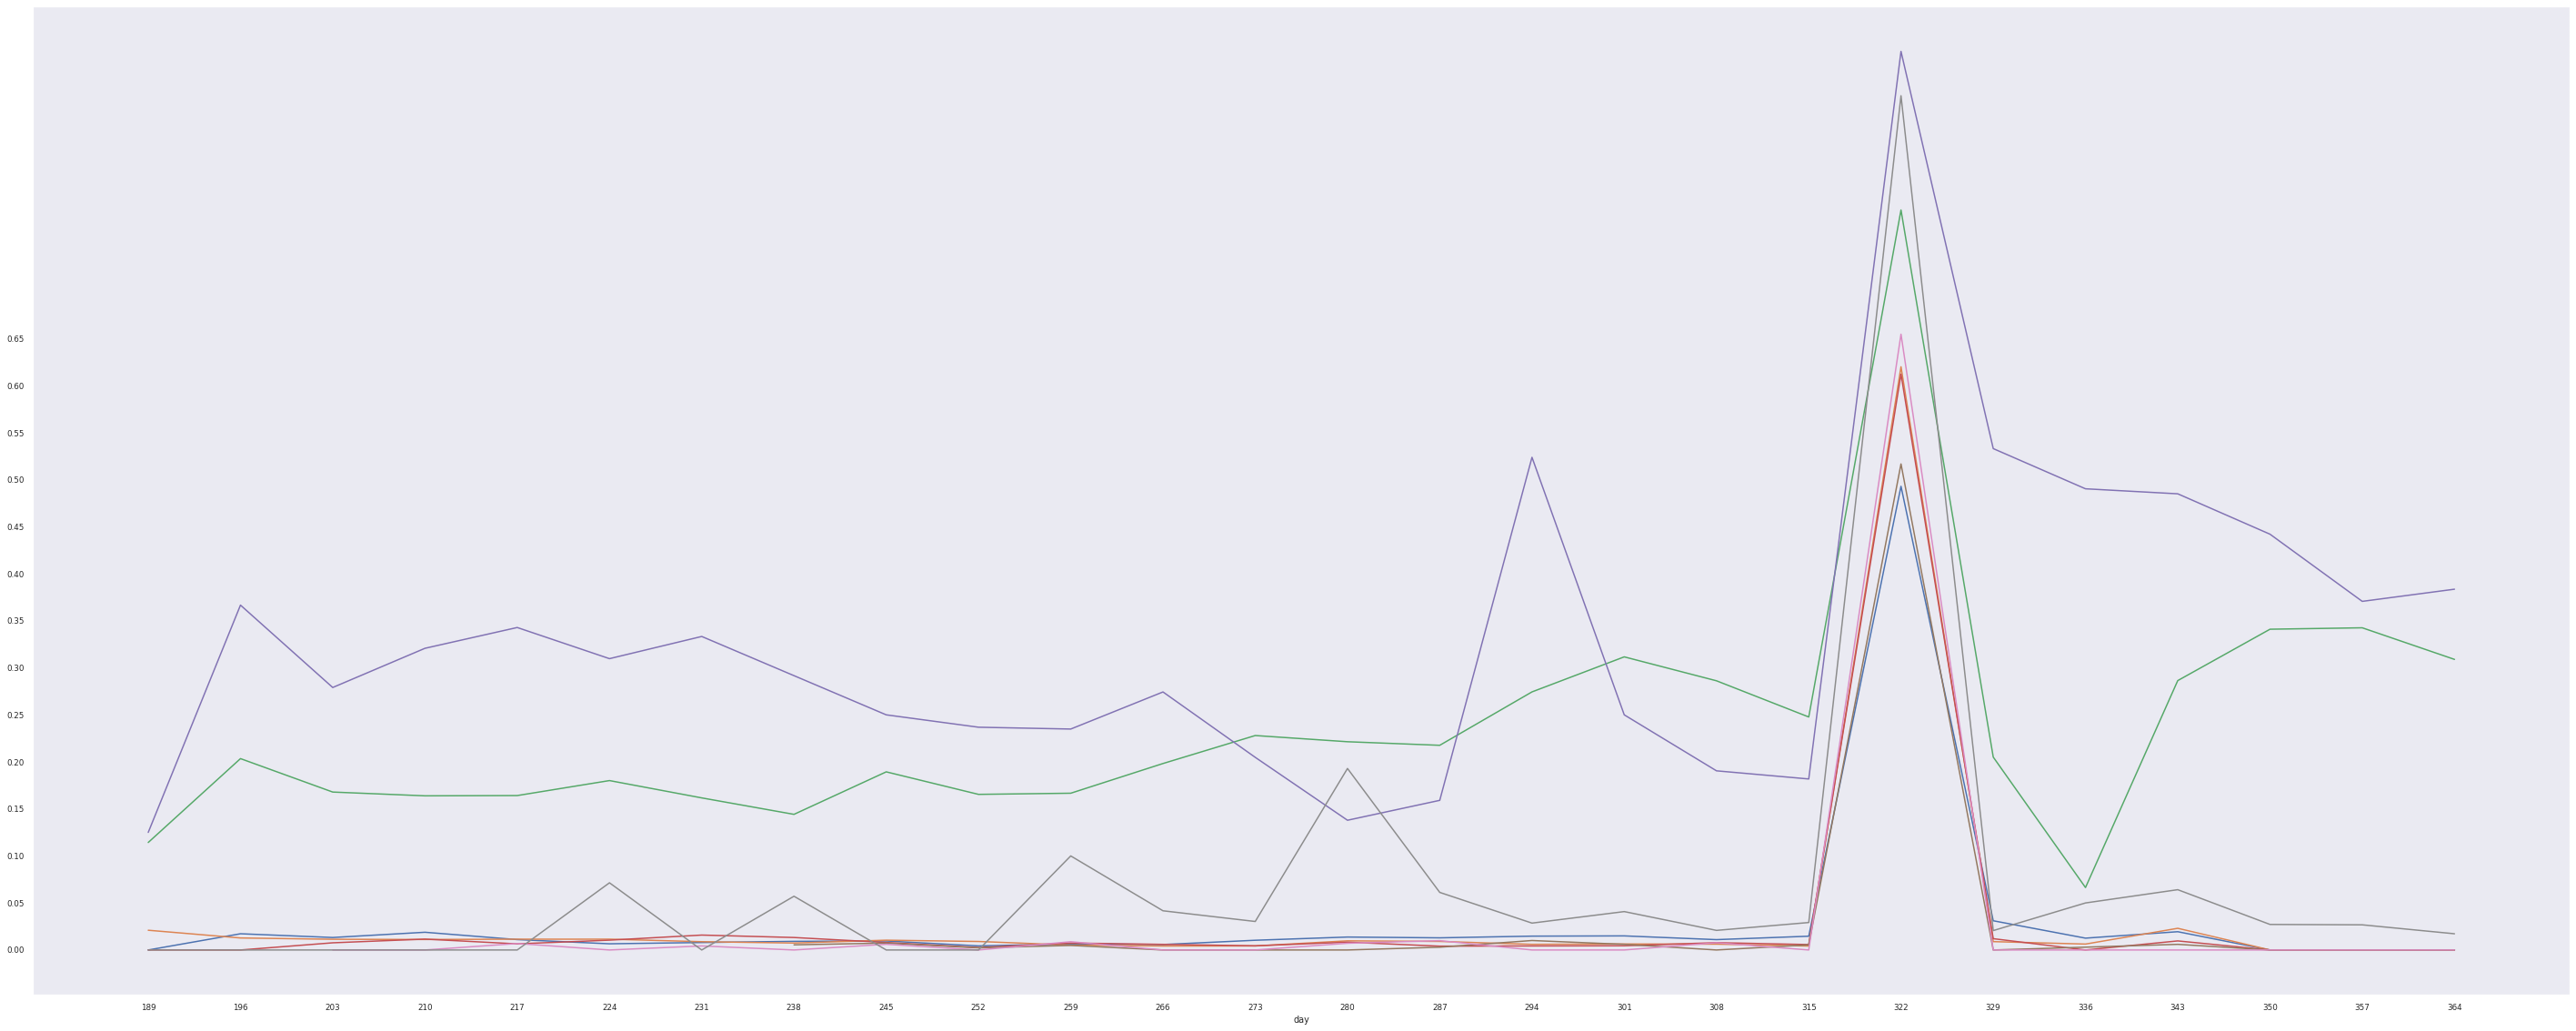

In [106]:
def buy_time_change(X):
    """Функция преобразует Unix time в другие форматы и ищет новизну предложения"""
    from datetime import datetime, date, time, timedelta
    import holidays
    from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
    X=X.copy()
    X['date'] = list(map(datetime.fromtimestamp,X['buy_time_train']))
    X['month'] = X['date'].apply(lambda x: x.timetuple()[1])
    X['day'] = X['date'].apply(lambda x: x.timetuple()[7])
    # неделя года
    X['weekofyear'] = X['buy_time_train'].apply(lambda x: pd.to_datetime(date.fromtimestamp(x)).weekofyear)
    X['time_max'] = X.buy_time_train.max()
        # Новизна предложения
    X['novelty'] = X['time_max'] - X['buy_time_train']
    # эти признаки оказались бесполезными
    #df_all['weekday'] = df_all['date'].apply(lambda x: x.timetuple()[6])
    # data['year'] = data['date'].map(lambda x: x.year)
    #df_all['hour'] = df_all['date'].map(lambda x: x.hour)
    #df_all['is_holiday'] = df_all['date'].map(lambda x: x in holidays.RU())
    return X

train = buy_time_change(train)
test = buy_time_change(test)

plt.figure(figsize=(50, 20))
train.loc[train['vas_id'] == 1].groupby(['day'])['target'].apply(lambda x: sum(x) / len(x)).plot()
train.loc[train['vas_id'] == 2].groupby(['day'])['target'].apply(lambda x: sum(x) / len(x)).plot()
train.loc[train['vas_id'] == 4].groupby(['day'])['target'].apply(lambda x: sum(x) / len(x)).plot()
train.loc[train['vas_id'] == 5].groupby(['day'])['target'].apply(lambda x: sum(x) / len(x)).plot()
train.loc[train['vas_id'] == 6].groupby(['day'])['target'].apply(lambda x: sum(x) / len(x)).plot()
train.loc[train['vas_id'] == 7].groupby(['day'])['target'].apply(lambda x: sum(x) / len(x)).plot()
train.loc[train['vas_id'] == 8].groupby(['day'])['target'].apply(lambda x: sum(x) / len(x)).plot()
train.loc[train['vas_id'] == 9].groupby(['day'])['target'].apply(lambda x: sum(x) / len(x)).plot()
plt.xticks(train['day'].unique())
plt.yticks(np.arange(0, 0.7, 0.05))
plt.grid()
plt.show()

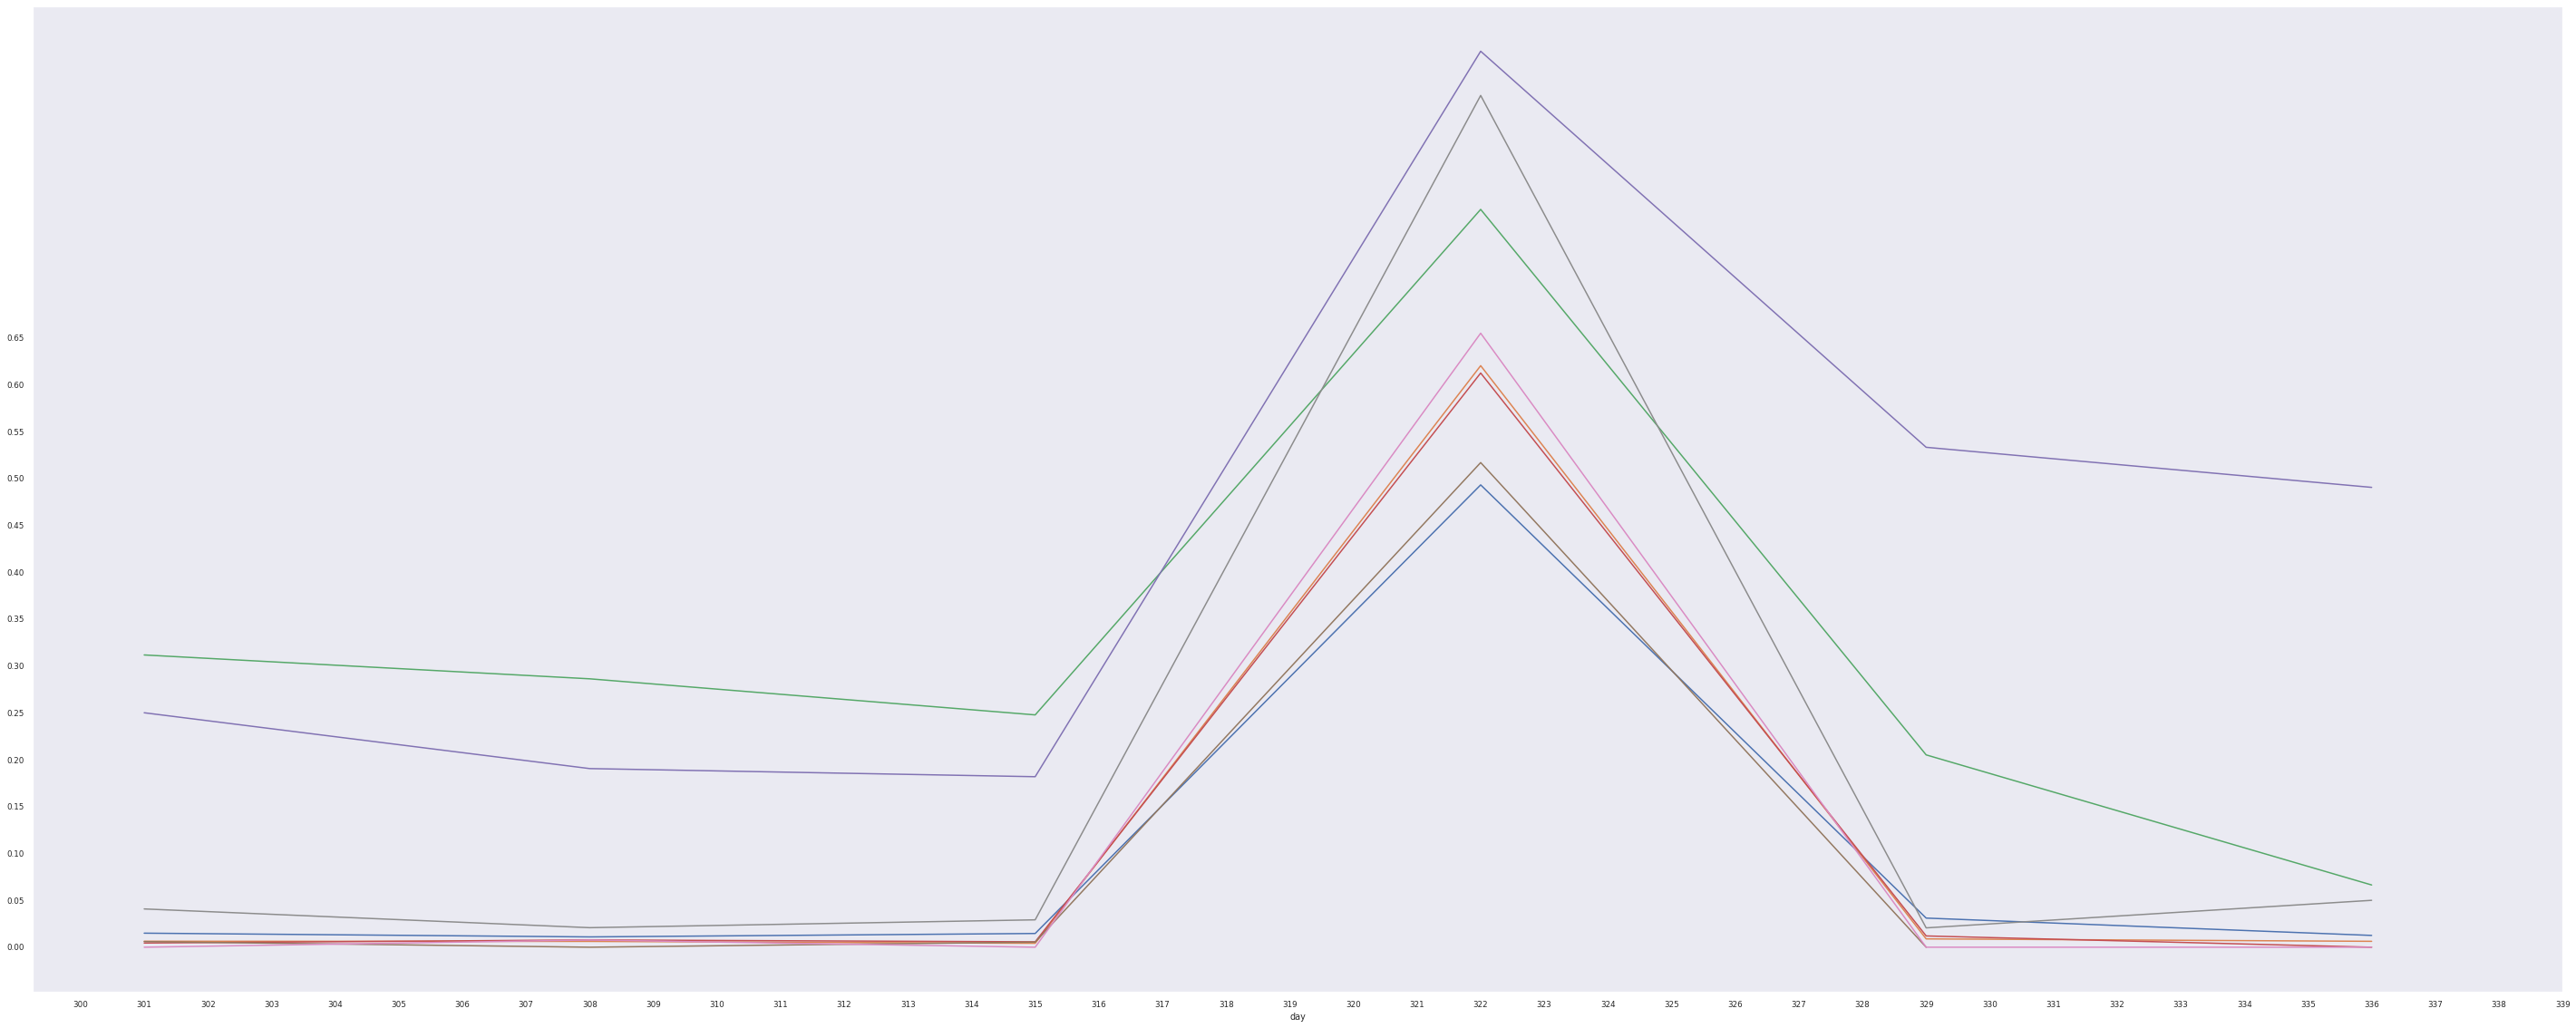

In [107]:
plt.figure(figsize=(50, 20))
train.loc[(train['vas_id'] == 1) & (train['day'] > 300) & (train['day'] < 340)].groupby(['day'])['target'].apply(lambda x: sum(x) / len(x)).plot()
train.loc[(train['vas_id'] == 2) & (train['day'] > 300) & (train['day'] < 340)].groupby(['day'])['target'].apply(lambda x: sum(x) / len(x)).plot()
train.loc[(train['vas_id'] == 4) & (train['day'] > 300) & (train['day'] < 340)].groupby(['day'])['target'].apply(lambda x: sum(x) / len(x)).plot()
train.loc[(train['vas_id'] == 5) & (train['day'] > 300) & (train['day'] < 340)].groupby(['day'])['target'].apply(lambda x: sum(x) / len(x)).plot()
train.loc[(train['vas_id'] == 6) & (train['day'] > 300) & (train['day'] < 340)].groupby(['day'])['target'].apply(lambda x: sum(x) / len(x)).plot()
train.loc[(train['vas_id'] == 7) & (train['day'] > 300) & (train['day'] < 340)].groupby(['day'])['target'].apply(lambda x: sum(x) / len(x)).plot()
train.loc[(train['vas_id'] == 8) & (train['day'] > 300) & (train['day'] < 340)].groupby(['day'])['target'].apply(lambda x: sum(x) / len(x)).plot()
train.loc[(train['vas_id'] == 9) & (train['day'] > 300) & (train['day'] < 340)].groupby(['day'])['target'].apply(lambda x: sum(x) / len(x)).plot()

plt.xticks(np.arange(300, 340, 1))
plt.yticks(np.arange(0, 0.7, 0.05))
plt.grid()
plt.show()

Все выбросы-акции с 315 по 329 день. Есть vas_id, где львиная доля продаж именно по акции.

Claster: 1


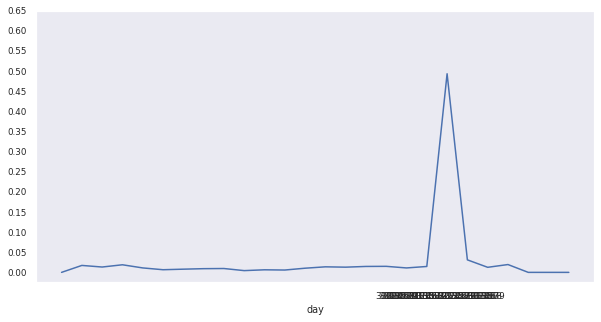

Claster: 2


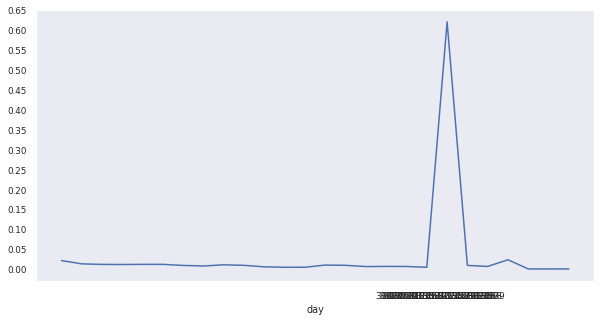

Claster: 4


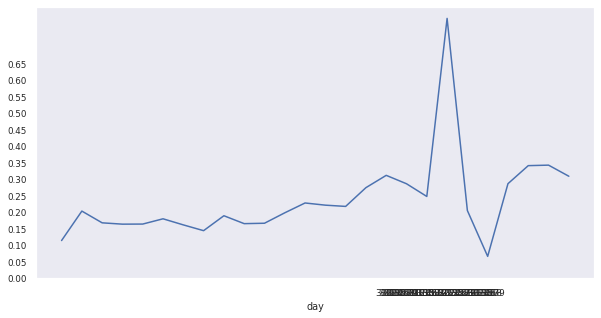

Claster: 5


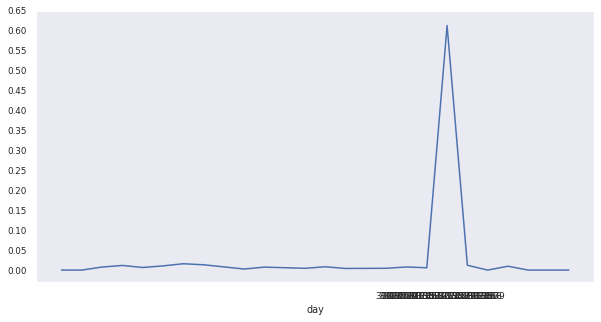

Claster: 6


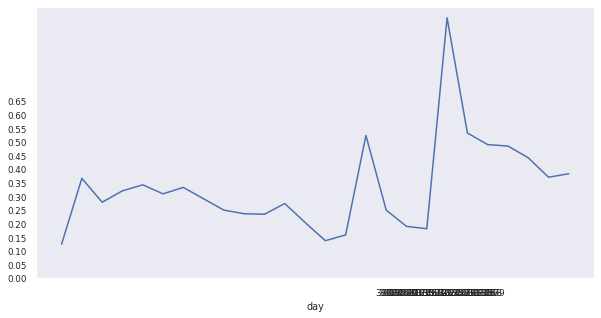

Claster: 7


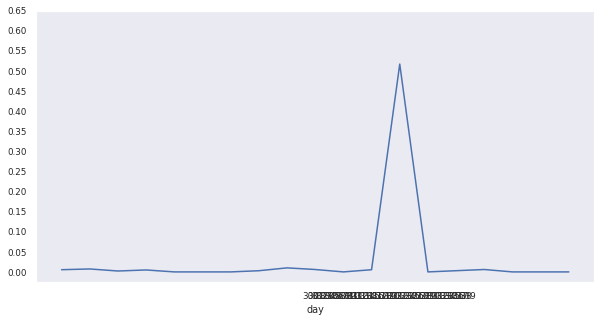

Claster: 8


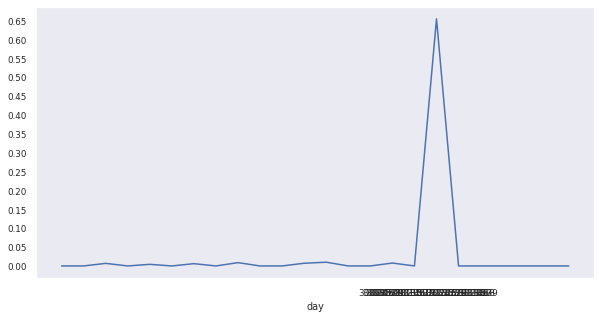

Claster: 9


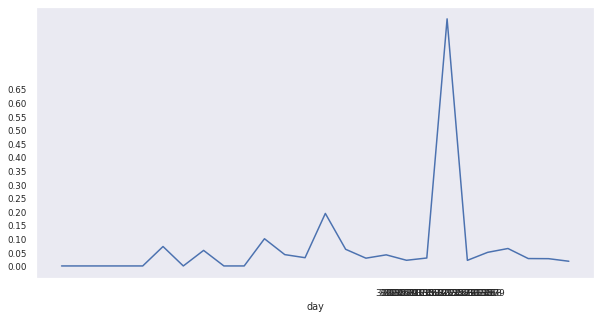

In [108]:
for i in [1,2,4,5,6,7,8,9]:
    print(f"Claster: {i}")
    plt.figure(figsize=(10, 5))
    train.loc[(train['vas_id'] == i)].groupby(['day'])['target']\
                        .apply(lambda x: sum(x) / len(x)).plot()
    plt.xticks(np.arange(300, 340, 1))
    plt.yticks(np.arange(0, 0.7, 0.05))
    plt.grid()
    plt.show()

Услуги 6, 4 и 9 продавались лучше всего. При этом услуга 9 составляет очень малую долю в общем количестве продаж. Количественные значения зафиксированы функцией choise_features для каждого из  vas_id.

До 315 дня основные подключаемые услуги были 4, 6 и 9, при этом услуга 4 постепенно вытесняла услугу 6. Потом доля услуги 4 значительно сократилась, но также значительно выросла доля услуги 6, т.е. произошло обратное замещение. Остальные услуги продавались в незначительно малом количестве. Аналогичная картина с небольшим смещением даты наблюдается в структуре предложения.

Услуга 9 показала необъяснимый всплеск продаж - на два порядка выше медианы. Достоверен ли он - не понять никак.

In [109]:
test

target       id  buy_time_train  vas_id  time_delta  component_1  \
0          1.0   718465      1535317200       2   2419200.0 -126710296.0   
1          0.0  2342608      1544994000       4   6652800.0 -126710296.0   
2          0.0  3807550      1538341200       4   1209600.0 -126710296.0   
3          0.0  1830223      1544994000       5   1814400.0 -126710296.0   
4          0.0  3072174      1545598800       1   6652800.0 -126710296.0   
...        ...      ...             ...     ...         ...          ...   
122613     0.0  2067092      1535922000       1   4233600.0 -126710296.0   
122614     0.0  2845532      1545598800       2    604800.0 -126710296.0   
122615     0.0  4303420      1538946000       1   7257600.0 -126710296.0   
122616     0.0  3712811      1538341200       1   5443200.0 -126710296.0   
122617     0.0  1149070      1546203600       5   3628800.0 -126710296.0   

        component_3                date  month  day  weekofyear    time_max  \
0      -5003.981445 2018-08-26 21:00:00      8  238          34  1546203600   
1      -5003.981445 2018-12-16 21:00:00     12  350          50  1546203600   
2      -5003.981445 2018-09-30 21:00:00      9  273          39  1546203600   
3      -5003.981445 2018-12-16 21:00:00     12  350          50  1546203600   
4      -5003.981445 2018-12-23 21:00:00     12  357          51  1546203600   
...             ...                 ...    ...  ...         ...         ...   
122613 -5003.981445 2018-09-02 21:00:00      9  245          35  1546203600   
122614 -5003.981445 2018-12-23 21:00:00     12  357          51  1546203600   
122615 -5003.981934 2018-10-07 21:00:00     10  280          40  1546203600   
122616 -5003.981934 2018-09-30 21:00:00      9  273          39  1546203600   
122617 -5003.981934 2018-12-30 21:00:00     12  364          52  1546203600   

         novelty  
0       10886400  
1        1209600  
2        7862400  
3        1209600  
4         604800  
...          ...  
122613  10281600  
122614    604800  
122615   7257600  
122616   7862400  
122617         0  

[122618 rows x 13 columns]

In [110]:
if 1:
    train.to_csv('train.csv', index=False)
    test.to_csv('test.csv', index=False)

# Исследование выбросов

In [111]:
from sklearn.ensemble import IsolationForest

In [119]:
isf = IsolationForest(n_estimators=20, random_state=42, contamination=0.02)
preds = isf.fit_predict(train.drop(columns=['target', 'id', 'date']))

train["iso_forest_outliers"] = preds
#train["iso_forest_scores"] = isf.decision_function(train.drop(columns=['target', 'id', 'date', "iso_forest_outliers"]))

print(train["iso_forest_outliers"].value_counts())
train_outliers = train.loc[train['iso_forest_outliers']== -1]
train_out = train.loc[train['iso_forest_outliers']== 1].drop(columns=['iso_forest_outliers', "iso_forest_outliers"])
train_out.head()

X does not have valid feature names, but IsolationForest was fitted with feature names


 1    280393
-1      5713
Name: iso_forest_outliers, dtype: int64


target       id  buy_time_train  vas_id  time_delta  component_1  \
0     0.0   253322      1541970000       4   6652800.0 -126705336.0   
1     0.0  2983908      1534107600       1   1209600.0 -126710392.0   
2     1.0  2031593      1543784400       6    604800.0 -126710376.0   
3     1.0    97940      1544994000       6   3628800.0 -126710376.0   
4     0.0     7923      1544994000       1  12700800.0 -126710376.0   

   component_3                date  month  day  weekofyear    time_max  \
0 -4995.636230 2018-11-11 21:00:00     11  315          45  1546203600   
1 -5079.392578 2018-08-12 21:00:00      8  224          32  1546203600   
2 -5001.316895 2018-12-02 21:00:00     12  336          48  1546203600   
3 -5003.815918 2018-12-16 21:00:00     12  350          50  1546203600   
4 -5003.792480 2018-12-16 21:00:00     12  350          50  1546203600   

    novelty  
0   4233600  
1  12096000  
2   2419200  
3   1209600  
4   1209600

In [121]:
#plot_hist(train["iso_forest_scores"], title="Гистограмма iso_forest_scores", xlabel="iso forest score")

In [120]:
fea_imp = choise_features(train_out, test, ['vas_id'])

0.0    0.909359
1.0    0.090641
Name: target, dtype: float64

0.0    0.909255
1.0    0.090745
Name: target, dtype: float64

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    254978
         1.0       0.40      0.95      0.56     25415

    accuracy                           0.87    280393
   macro avg       0.70      0.90      0.74    280393
weighted avg       0.94      0.87      0.89    280393

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    111491
         1.0       0.39      0.94      0.56     11127

    accuracy                           0.86    122618
   macro avg       0.69      0.90      0.74    122618
weighted avg       0.94      0.86      0.89    122618

CONFUSION MATRIX

col_0     0.0    1.0
target              
0.0     95407  16084
1.0       657  10470


In [125]:
fea_imp = choise_features(train.drop(columns=['iso_forest_outliers']), test, ['vas_id'])

0.0    0.90925
1.0    0.09075
Name: target, dtype: float64

0.0    0.909255
1.0    0.090745
Name: target, dtype: float64

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    260142
         1.0       0.40      0.95      0.56     25964

    accuracy                           0.87    286106
   macro avg       0.70      0.90      0.74    286106
weighted avg       0.94      0.87      0.89    286106

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    111491
         1.0       0.39      0.94      0.56     11127

    accuracy                           0.86    122618
   macro avg       0.69      0.90      0.74    122618
weighted avg       0.94      0.86      0.89    122618

CONFUSION MATRIX

col_0     0.0    1.0
target              
0.0     95414  16077
1.0       657  10470


Метрики не изменились. Подстраивать под себя датасет не буду. Буду обучать с выбросами.

In [126]:
del train_out, train_outliers

In [127]:
train.drop(columns=['iso_forest_outliers'], inplace=True)

# Генерация признаков логирования офферов абонентам

In [128]:
def get_offer_count(df):
    """id пользователей для которых было несколько предложени"""
    b = pd.DataFrame(df['id'].value_counts()) # все id
    few = b.loc[b['id']>1] # id,  у которых количество больше одного. 
    return few

In [129]:
train_few = get_offer_count(train)
len(train_few)

5546

In [130]:
test_few = get_offer_count(test)
len(test_few)

982

In [131]:
test.head()

target       id  buy_time_train  vas_id  time_delta  component_1  \
0     1.0   718465      1535317200       2   2419200.0 -126710296.0   
1     0.0  2342608      1544994000       4   6652800.0 -126710296.0   
2     0.0  3807550      1538341200       4   1209600.0 -126710296.0   
3     0.0  1830223      1544994000       5   1814400.0 -126710296.0   
4     0.0  3072174      1545598800       1   6652800.0 -126710296.0   

   component_3                date  month  day  weekofyear    time_max  \
0 -5003.981445 2018-08-26 21:00:00      8  238          34  1546203600   
1 -5003.981445 2018-12-16 21:00:00     12  350          50  1546203600   
2 -5003.981445 2018-09-30 21:00:00      9  273          39  1546203600   
3 -5003.981445 2018-12-16 21:00:00     12  350          50  1546203600   
4 -5003.981445 2018-12-23 21:00:00     12  357          51  1546203600   

    novelty  
0  10886400  
1   1209600  
2   7862400  
3   1209600  
4    604800

In [132]:
def log_feature_1(few,df):
    """история по всем предложениям.
    - если есть 3 предложения, т.е. в таблице 3 строки и в каждой будет храниться история про другие предложения, т.е. если РАЗНЫХ предложений 3, то в каждой (из трех) строк во всех трех столбцах будет стоять 1.
    - если 2 одинаковых предложения, то в каждой строке в соответствующем столбце будет стоять 2"""
    df['vas_id_1'] = 0 # для каждой услуги свой столбец
    df['vas_id_2'] = 0
    df['vas_id_4'] = 0
    df['vas_id_5'] = 0
    df['vas_id_6'] = 0
    df['vas_id_7'] = 0
    df['vas_id_8'] = 0
    df['vas_id_9'] = 0
    
    # цикл у нас только по тем пользователям у которых больше одного предложения
    # таких пользователей мы отобрали в предыдущей функции get_offer_count
    for i in few.index:
        # в целом конструкция аналогична df.loc[df['id']==i].groupby(['vas_id'])['vas_id'].count()
        a = df.loc[df['id']==i,'vas_id'].value_counts()
        # a = df.loc[df['id']==i].groupby(['vas_id'])['vas_id'].count()
        for k in a.index:
            df.loc[df['id']==i,'vas_id_'+str(int(k))] = a[k]

In [133]:
log_feature_1(train_few, train)

In [134]:
log_feature_1(test_few, test)

In [135]:
test.head()

target       id  buy_time_train  vas_id  time_delta  component_1  \
0     1.0   718465      1535317200       2   2419200.0 -126710296.0   
1     0.0  2342608      1544994000       4   6652800.0 -126710296.0   
2     0.0  3807550      1538341200       4   1209600.0 -126710296.0   
3     0.0  1830223      1544994000       5   1814400.0 -126710296.0   
4     0.0  3072174      1545598800       1   6652800.0 -126710296.0   

   component_3                date  month  day  ...    time_max   novelty  \
0 -5003.981445 2018-08-26 21:00:00      8  238  ...  1546203600  10886400   
1 -5003.981445 2018-12-16 21:00:00     12  350  ...  1546203600   1209600   
2 -5003.981445 2018-09-30 21:00:00      9  273  ...  1546203600   7862400   
3 -5003.981445 2018-12-16 21:00:00     12  350  ...  1546203600   1209600   
4 -5003.981445 2018-12-23 21:00:00     12  357  ...  1546203600    604800   

   vas_id_1  vas_id_2  vas_id_4  vas_id_5  vas_id_6  vas_id_7  vas_id_8  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   vas_id_9  
0         0  
1         0  
2         0  
3         0  
4         0  

[5 rows x 21 columns]

In [136]:
def log_feature_2(few,df):
    """В этой фиче порядковый номер для одинаковых предложений для одного пользователя, то есть если одному пользователю 2 раза предлагали
     одну и ту же услугу, то первая по времени услуга будет с номером 1, а вторая с номером 2"""
    df['vas_id_ord'] = 0

    # цикл у нас только по тем пользователям у которых больше одного предложения
    # таких пользователей мы отобрали в предыдущей функции get_offer_count   
    for i in few.index:
        # тут получаем историю предложений для конкретного пользователя
        # историю мы сформировали ранее в функции log_feature_1
        a = df.loc[(df['id']==i),['vas_id_1', 'vas_id_2', 'vas_id_4', 'vas_id_5', 'vas_id_6', 'vas_id_7', 'vas_id_8', 'vas_id_9']]
        # это мы получили номер столбца, он же номер услуги (vas_id: 1-9), в котором стоит больше 1, 
        # т.е. предложение делалось клиенту более одного раза
        # т.е. если предложений 3, то в каждой строке хранится полная история и мы берем первую строку и те столбцы где >1
        aa = a.iloc[0][a.iloc[0].values>1]
        # если есть такие столбцы, т.е. если пользователю предлагали одну услугу более одного раза
        # тут мы исходим из того, что ни одну услугу не предлагали 3 раза одному клиенту, максимум 2
        if len(aa) > 0:
            j = aa.index[0][7:] # это мы взяли номер такой услуги, выдрали из названия столбца
            # отсортировали записи о предложении услуги по возрастанию даты
            a = df.loc[(df['id']==i)&(df['vas_id']==float(j))].sort_values(by='buy_time_train', ascending=True)
            # для первой поставили номер 1 для второй номер 2
            for k in range(a.shape[0]):
                df.loc[a.index[k],'vas_id_ord'] = k+1

In [137]:
log_feature_2(train_few, train)

In [138]:
log_feature_2(test_few, test)

In [139]:
test.isna().sum().sum()

0

In [140]:
test.head()

target       id  buy_time_train  vas_id  time_delta  component_1  \
0     1.0   718465      1535317200       2   2419200.0 -126710296.0   
1     0.0  2342608      1544994000       4   6652800.0 -126710296.0   
2     0.0  3807550      1538341200       4   1209600.0 -126710296.0   
3     0.0  1830223      1544994000       5   1814400.0 -126710296.0   
4     0.0  3072174      1545598800       1   6652800.0 -126710296.0   

   component_3                date  month  day  ...   novelty  vas_id_1  \
0 -5003.981445 2018-08-26 21:00:00      8  238  ...  10886400         0   
1 -5003.981445 2018-12-16 21:00:00     12  350  ...   1209600         0   
2 -5003.981445 2018-09-30 21:00:00      9  273  ...   7862400         0   
3 -5003.981445 2018-12-16 21:00:00     12  350  ...   1209600         0   
4 -5003.981445 2018-12-23 21:00:00     12  357  ...    604800         0   

   vas_id_2  vas_id_4  vas_id_5  vas_id_6  vas_id_7  vas_id_8  vas_id_9  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   vas_id_ord  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 22 columns]

In [141]:
def log_feature_3(few,df):
    """В этой фиче разница по датам для одинаковых предложений.
    Для первого предложения всегда 0, для второго +разница в днях+1 и т.д.
    Если предложения в один день, то между ними стоит 1 (разница в днях 0+1). 
    Если оставить 0, то тогда не будет разницы между первыми и повторными предложениями"""

    df['vas_id_date_dif_1'] = 0

    # цикл у нас только по тем пользователям у которых больше одного предложения
    # таких пользователей мы отобрали в предыдущей функции get_proposal_count       
    for i in few.index:
        # тут получаем историю предложений для конкретного пользователя
        # историю мы сформировали ранее в функции hist_columns_1
        a = df.loc[(df['id']==i),['vas_id_1', 'vas_id_2', 'vas_id_4', 'vas_id_5', 'vas_id_6', 'vas_id_7', 'vas_id_8', 'vas_id_9']]
        # это мы получили номер столбца, он же номер услуги (vas_id: 1-9), в котором стоит больше 1, 
        # т.е. предложение делалось клиенту более одного раза
        # т.е. если предложений 3, то в каждой строке хранится полная история и мы бурум первую строку и те столбцы где >1
        aa = a.iloc[0][a.iloc[0].values>1]
        # если есть такие столбцы, т.е. если пользователю предлагали одну услугу более одного раза
        # тут мы исходим из того, что ни одну услугу не предлагали 3 раза одному клиенту, максимум 2
        if len(aa) > 0:
            j = aa.index[0][7:] # это мы взяли номер такой услуги, выдрали из названия столбца
            # эту услугу предлагали 2 раза, значит у нас есть столбец в котором стоит порядковый номер для такой услуги
            # мы его сделали ранее в функции hist_columns_2
            # поэтому первая услуга та, у которой в этом столбце 1, вторая - та, у которой 2.
            # находим разность по датам для этих услуг
            d1 = df.loc[(df['id']==i)&(df['vas_id']==float(j))&(df['vas_id_ord']==1),'date']
            d2 = df.loc[(df['id']==i)&(df['vas_id']==float(j))&(df['vas_id_ord']==2),'date']
            df.loc[(df['id']==i)&(df['vas_id']==float(j))&(df['vas_id_ord']==2),'vas_id_date_dif_1'] = \
                 (pd.to_datetime(d2.values[0])-pd.to_datetime(d1.values[0])).days + 1                                                                                                                                        

In [142]:
log_feature_3(train_few, train)

In [143]:
log_feature_3(test_few, test)

In [144]:
test.isna().sum().sum()

0

In [145]:
test.head()

target       id  buy_time_train  vas_id  time_delta  component_1  \
0     1.0   718465      1535317200       2   2419200.0 -126710296.0   
1     0.0  2342608      1544994000       4   6652800.0 -126710296.0   
2     0.0  3807550      1538341200       4   1209600.0 -126710296.0   
3     0.0  1830223      1544994000       5   1814400.0 -126710296.0   
4     0.0  3072174      1545598800       1   6652800.0 -126710296.0   

   component_3                date  month  day  ...  vas_id_1  vas_id_2  \
0 -5003.981445 2018-08-26 21:00:00      8  238  ...         0         0   
1 -5003.981445 2018-12-16 21:00:00     12  350  ...         0         0   
2 -5003.981445 2018-09-30 21:00:00      9  273  ...         0         0   
3 -5003.981445 2018-12-16 21:00:00     12  350  ...         0         0   
4 -5003.981445 2018-12-23 21:00:00     12  357  ...         0         0   

   vas_id_4  vas_id_5  vas_id_6  vas_id_7  vas_id_8  vas_id_9  vas_id_ord  \
0         0         0         0         0         0         0           0   
1         0         0         0         0         0         0           0   
2         0         0         0         0         0         0           0   
3         0         0         0         0         0         0           0   
4         0         0         0         0         0         0           0   

   vas_id_date_dif_1  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 23 columns]

In [146]:
def log_feature_4(few,df):
    """В этой фиче разница между всеми предложениями для одного клиента.
    Для первого предложения всега 0, для второго +разница в днях+1 и т.д.
    Если предложения в один день, то между ними стоит 1 (разница в днях 0+1). 
    Если оставить 0, то тогда не будет разницы между первыми и повторными предложениями."""

    df['vas_id_date_dif_2'] = 0
    
    # цикл у нас только по тем пользователям у которых больше одного предложения
    # таких пользователей мы отобрали в предыдущей функции get_proposal_count   
    for i in few.index:
        # получили все предложения пользователя и отсортировали все предложения по дате
        a = df.loc[(df['id']==i)].sort_values(by='buy_time_train', ascending=True)
        # идем в цикле по предложениям начиная с 1го, не с 0го.
        for k in range(1,a.shape[0]):
            d1 = df.loc[a.index[k-1],'date'] # предыдущее предложение
            d2 = df.loc[a.index[k],'date'] # первое предложение
            df.loc[a.index[k],'vas_id_date_dif_2'] = (pd.to_datetime(d2)-pd.to_datetime(d1)).days #  + 1 этого не было, только здесь добавила
            # если предложений 3 и 2ое и 3е дали в один день (одновременно), 
            # то у них разница с предыдущим предложением будет одинаковая
            # т.е. тут предыдущим предложением считаем первое предложение
            if (k==2) & ((pd.to_datetime(d2)-pd.to_datetime(d1)).days==0):
                df.loc[a.index[k],'vas_id_date_dif_2'] = df.loc[a.index[k-1],'vas_id_date_dif_2']

In [147]:
log_feature_4(train_few, train)

In [148]:
log_feature_4(test_few, test)

In [149]:
test.isna().sum().sum()

0

In [150]:
test.head()

target       id  buy_time_train  vas_id  time_delta  component_1  \
0     1.0   718465      1535317200       2   2419200.0 -126710296.0   
1     0.0  2342608      1544994000       4   6652800.0 -126710296.0   
2     0.0  3807550      1538341200       4   1209600.0 -126710296.0   
3     0.0  1830223      1544994000       5   1814400.0 -126710296.0   
4     0.0  3072174      1545598800       1   6652800.0 -126710296.0   

   component_3                date  month  day  ...  vas_id_2  vas_id_4  \
0 -5003.981445 2018-08-26 21:00:00      8  238  ...         0         0   
1 -5003.981445 2018-12-16 21:00:00     12  350  ...         0         0   
2 -5003.981445 2018-09-30 21:00:00      9  273  ...         0         0   
3 -5003.981445 2018-12-16 21:00:00     12  350  ...         0         0   
4 -5003.981445 2018-12-23 21:00:00     12  357  ...         0         0   

   vas_id_5  vas_id_6  vas_id_7  vas_id_8  vas_id_9  vas_id_ord  \
0         0         0         0         0         0           0   
1         0         0         0         0         0           0   
2         0         0         0         0         0           0   
3         0         0         0         0         0           0   
4         0         0         0         0         0           0   

   vas_id_date_dif_1  vas_id_date_dif_2  
0                  0                  0  
1                  0                  0  
2                  0                  0  
3                  0                  0  
4                  0                  0  

[5 rows x 24 columns]

In [151]:
train.drop(columns=['date'], inplace=True)
test.drop(columns=['date'], inplace=True)

# Генерация признака того, что оффер был принят по распродаже (на временном выбросе)

In [152]:
class Is_action:

    def __init__(self, train, start, stop):
        self.X = train.drop(columns=['target'])
        self.y = train['target']
        self.start = start
        self.stop = stop
        self.model = None


    def fit(self):
        """Обучает Catboost"""
        self.X['is_action'] = 0
        self.X.loc[((self.X['day'] > self.start) & (self.X['day'] < self.stop) & (y==1)), 'is_action'] = 1
        X_action = self.X.drop(columns=['is_action'])
        y_action = self.X['is_action']
        disbalance = y_action.value_counts()[0] / y_action.value_counts()[1]
        
        frozen_params = {
             'class_weights':[1, disbalance], 
             'silent':True,
             'random_state':21,
             'eval_metric':'F1',
             'early_stopping_rounds':60
        }

        self.model = catb.CatBoostClassifier(**frozen_params)                                             
        self.model.fit(X_action, y_action)
        y_pred = self.model.predict(X_action)
        print(classification_report(y_action, y_pred))
        
        #return self.model

    def transform(self, XX):
        XX=XX.copy()
        y_target = XX['target']
        X = XX.drop(columns=['target'])
        y_pred = self.model.predict(X)
        XX['is_action'] = y_pred
        XX['target'] = y_target
        
        return XX

is_action = Is_action(train, 315, 329)

is_action.fit()

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    285135
           1       0.14      1.00      0.25       971

    accuracy                           0.98    286106
   macro avg       0.57      0.99      0.62    286106
weighted avg       1.00      0.98      0.99    286106



f1-score для единиц всего 0,25. Делаю вывод что для выбранной модели акционные продажи не имеют значимости. Надо еще проверить статистическую значимость, но это в следующий раз))).

In [153]:
if 1:
    train.to_csv('train.csv', index=False)
    test.to_csv('test.csv', index=False)

# TARGET_ENCODING

In [154]:
cat_feats = list(train.nunique()[train.nunique() < 10].index)
cat_feats.remove('target')

In [155]:
def target_encoder(train, test, encoded):
    train, test = train.copy(, test.copy()
    Mask = pd.DataFrame(train.groupby(by=encoded)['target'].mean()).\
           rename(columns={"target": f"{encoded}_mean"})
    train = pd.merge(train, Mask, how='left', on=encoded)
    test = pd.merge(test, Mask, how='left', on=encoded)
    
    return train, test

In [156]:
train, test = target_encoder(train, test, 'vas_id')
feature_importances = choise_features(train, test, cat_feats)

0.0    0.90925
1.0    0.09075
Name: target, dtype: float64

0.0    0.909255
1.0    0.090745
Name: target, dtype: float64

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.86      0.92    260142
         1.0       0.40      0.96      0.56     25964

    accuracy                           0.86    286106
   macro avg       0.70      0.91      0.74    286106
weighted avg       0.94      0.86      0.89    286106

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    111491
         1.0       0.40      0.95      0.56     11127

    accuracy                           0.86    122618
   macro avg       0.69      0.90      0.74    122618
weighted avg       0.94      0.86      0.89    122618

CONFUSION MATRIX

col_0     0.0    1.0
target              
0.0     95367  16124
1.0       582  10545


Есть небольшое улучшение. Таргетэнкодинг по остальным фичам не помог.

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


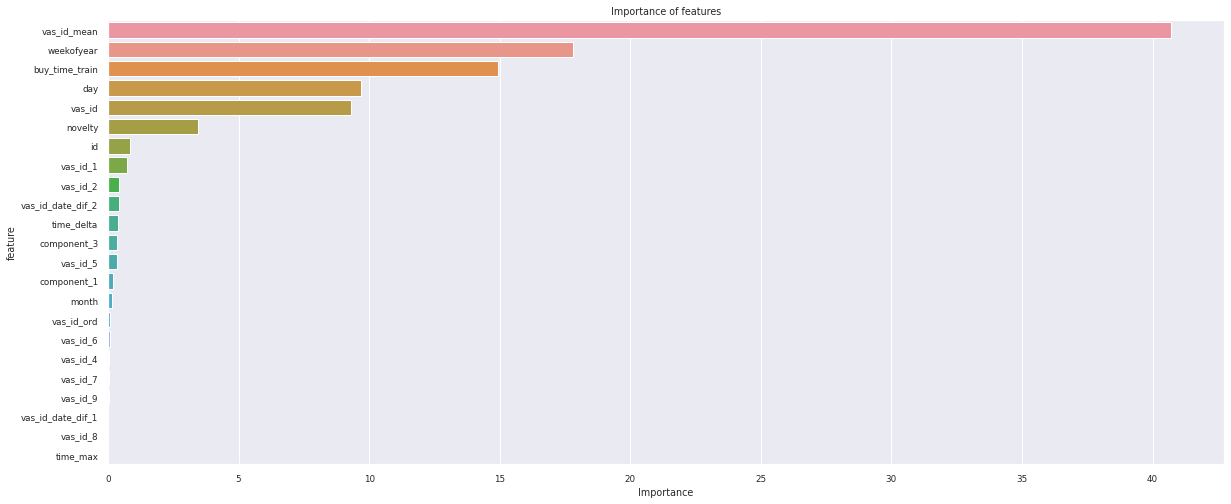

['vas_id_mean',
 'weekofyear',
 'buy_time_train',
 'day',
 'vas_id',
 'novelty',
 'id',
 'vas_id_1',
 'vas_id_2',
 'vas_id_date_dif_2',
 'time_delta',
 'component_3',
 'vas_id_5',
 'component_1',
 'month']

In [157]:
show_feature_importances(feature_importances['feature_name'], feature_importances['importance'],\
                         get_top = 15)

In [159]:
if 1:
    train.to_csv('train.csv', index=False)
    test.to_csv('test.csv', index=False)

In [11]:
if 1:
    train = pd.read_csv(data_folder.joinpath('train.csv'))
    test = pd.read_csv(data_folder.joinpath('test.csv'))

In [14]:
train.head()

target       id  buy_time_train  vas_id  time_delta  component_1  \
0     0.0   253322      1541970000       4   6652800.0 -126705336.0   
1     0.0  2983908      1534107600       1   1209600.0 -126710390.0   
2     1.0  2031593      1543784400       6    604800.0 -126710376.0   
3     1.0    97940      1544994000       6   3628800.0 -126710376.0   
4     0.0     7923      1544994000       1  12700800.0 -126710376.0   

   component_3  month  day  weekofyear  ...  vas_id_5  vas_id_6  vas_id_7  \
0   -4995.6360     11  315          45  ...         0         0         0   
1   -5079.3926      8  224          32  ...         0         0         0   
2   -5001.3170     12  336          48  ...         0         0         0   
3   -5003.8160     12  350          50  ...         0         0         0   
4   -5003.7925     12  350          50  ...         0         0         0   

   vas_id_8  vas_id_9  vas_id_ord  vas_id_date_dif_1  vas_id_date_dif_2  \
0         0         0           0                  0                  0   
1         0         0           0                  0                  0   
2         0         0           0                  0                  0   
3         0         0           0                  0                  0   
4         0         0           0                  0                  0   

   vas_id_mean  log_vas_id_mean  
0     0.300095        -1.200329  
1     0.023038        -3.728128  
2     0.437451        -0.824507  
3     0.437451        -0.824507  
4     0.023038        -3.728128  

[5 rows x 26 columns]

переделал проверочную функцию

In [ ]:
def choise_features(train, test, cat_feats):
    """Функция для проверки метрик и выбора признаков, cat_feats для категориальных признаков"""
    X_train = train.drop(columns=['target'])
    y_train = train['target']
    X_test = test.drop(columns=['target'])
    y_test = test['target']

    display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))
    disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
    frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features': cat_feats,
     'eval_metric':'TotalF1',
     'early_stopping_rounds':40
    }    

    model_catb = catb.CatBoostClassifier(**frozen_params, iterations=300, max_depth=5)
    model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))
    evaluate_preds(model_catb, X_train, X_test, y_train, y_test)
    feature_importances = pd.DataFrame(zip(X_train.columns, model_catb.feature_importances_), 
                                       columns=['feature_name', 'importance'])
    feature_importances.sort_values(by='importance', ascending=False)

    return feature_importances

In [15]:
X_train = train.drop(columns=['target'])
y_train = train['target']
X_test = test.drop(columns=['target'])
y_test = test['target']

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features': ['vas_id'],
     'eval_metric':'TotalF1',
     'early_stopping_rounds':40
    }         

model_catb = catb.CatBoostClassifier(**frozen_params, iterations=300, max_depth=5)
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

0.0    0.90925
1.0    0.09075
Name: target, dtype: float64

0.0    0.909255
1.0    0.090745
Name: target, dtype: float64

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [18]:
y_pred = model_catb.predict_proba(X_test)

In [20]:
len(y_test)

122618

# Поиск лучшего трешхолда

In [22]:
for i in np.linspace(0.7, 0.9, num=10):
    print(f"threshold : {i}")
    print(classification_report(y_test, (y_pred[:, 1] > i) * 1))
    print('***************************')

threshold : 0.7
              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93    111491
         1.0       0.44      0.89      0.58     11127

    accuracy                           0.89    122618
   macro avg       0.71      0.89      0.76    122618
weighted avg       0.94      0.89      0.90    122618

***************************
threshold : 0.7222222222222222
              precision    recall  f1-score   support

         0.0       0.99      0.89      0.93    111491
         1.0       0.44      0.88      0.59     11127

    accuracy                           0.89    122618
   macro avg       0.71      0.89      0.76    122618
weighted avg       0.94      0.89      0.90    122618

***************************
threshold : 0.7444444444444445
              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94    111491
         1.0       0.45      0.87      0.59     11127

    accuracy                           0.89    1

# Исследование признаков с помощью SHAP

In [160]:
X_train, y_train = train.drop(columns=['target']), train['target']
X_test, y_test = test.drop(columns=['target']), test['target']
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
frozen_params = {
 'class_weights':[1, disbalance], 
 'silent':True,
 'random_state':21,
 'cat_features': cat_feats,
 'eval_metric':'TotalF1',
 'early_stopping_rounds':40
}    
model_catb = catb.CatBoostClassifier(**frozen_params, iterations=300, max_depth=5)
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [161]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model_catb)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

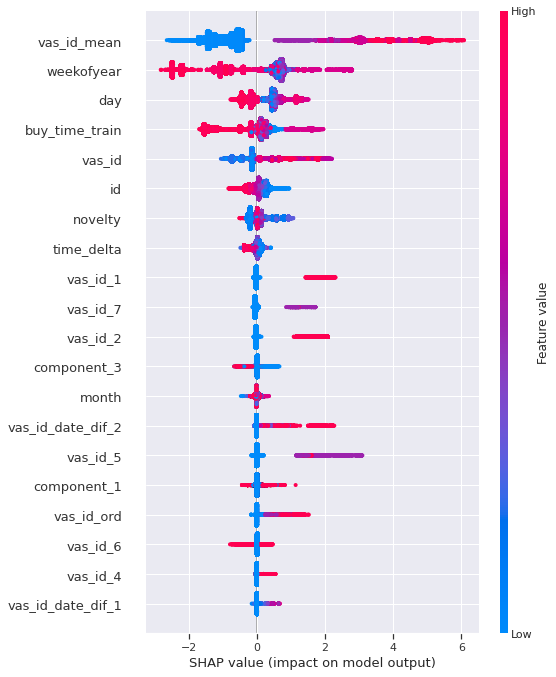

In [162]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

Как его читать:

значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1) чем толще линия на графике, тем больше таких точек наблюдения чем краснее точка на графике, тем выше значения признака в ней


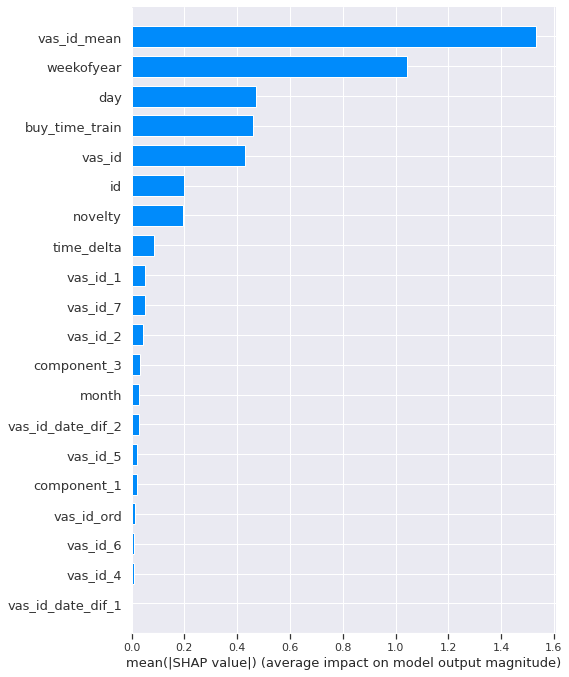

In [163]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [164]:
# Предсказание ухудшилось
feature_importances = choise_features(train.drop(columns=['buy_time_train']), test.drop(columns=['buy_time_train']), cat_feats)

0.0    0.90925
1.0    0.09075
Name: target, dtype: float64

0.0    0.909255
1.0    0.090745
Name: target, dtype: float64

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92    260142
         1.0       0.40      0.96      0.56     25964

    accuracy                           0.86    286106
   macro avg       0.70      0.91      0.74    286106
weighted avg       0.94      0.86      0.89    286106

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.85      0.92    111491
         1.0       0.39      0.95      0.56     11127

    accuracy                           0.86    122618
   macro avg       0.69      0.90      0.74    122618
weighted avg       0.94      0.86      0.89    122618

CONFUSION MATRIX

col_0     0.0    1.0
target              
0.0     95303  16188
1.0       581  10546


Метрики не изменились, удалять buy_time_train не буду.

# Автоматическая генерация признаков

In [165]:
def transform_data(data):
    for i1, col1 in enumerate(base_cols):
        data[col1 + '_log'] = np.log(data[col1] + 1.1)

        for i2, col2 in enumerate(base_cols):
            data['%s_%s_1' % (col1, col2)] = data[col1] - data[col2]
            data['%s_%s_2' % (col1, col2)] = data[col1] + data[col2]
            data['%s_%s_3' % (col1, col2)] = data[col1] / (data[col2] + 0.1)
            data['%s_%s_4' % (col1, col2)] = data[col1] * data[col2]

            data['%s_%s_11' % (col1, col2)] = data[col1] - np.log(data[col2] + 1)
            data['%s_%s_22' % (col1, col2)] = data[col1] + np.log(data[col2] + 1)
            data['%s_%s_33' % (col1, col2)] = data[col1] / (np.log(data[col2] + 1) + 0.1)
            data['%s_%s_44' % (col1, col2)] = data[col1] * np.log(data[col2] + 1)
            
            data['%s_%s_11' % (col1, col2)] = data[col1] - np.sqrt(data[col2] + 1)
            data['%s_%s_22' % (col1, col2)] = data[col1] + np.sqrt(data[col2] + 1)
            data['%s_%s_33' % (col1, col2)] = data[col1] / (np.sqrt(data[col2] + 1) + 0.1)
            data['%s_%s_44' % (col1, col2)] = data[col1] * np.sqrt(data[col2] + 1)
            
            data['%s_%s_11' % (col1, col2)] = data[col1] - (data[col2] + 1)**2
            data['%s_%s_22' % (col1, col2)] = data[col1] + (data[col2] + 1)**2
            data['%s_%s_33' % (col1, col2)] = data[col1] / ((data[col2] + 1) + 0.1)**2
            data['%s_%s_44' % (col1, col2)] = data[col1] * (data[col2] + 1)**2

    return data

In [169]:
base_cols = ['vas_id_mean','day','buy_time_train','weekofyear','novelty','vas_id',
    'month','time_delta']

In [170]:
train_exp = transform_data(train)
test_exp = transform_data(test)

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame

In [171]:
feature_importances = choise_features(train_exp, test_exp, cat_feats)

0.0    0.90925
1.0    0.09075
Name: target, dtype: float64

0.0    0.909255
1.0    0.090745
Name: target, dtype: float64

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92    260142
         1.0       0.40      0.96      0.56     25964

    accuracy                           0.86    286106
   macro avg       0.70      0.91      0.74    286106
weighted avg       0.94      0.86      0.89    286106

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    111491
         1.0       0.40      0.95      0.56     11127

    accuracy                           0.86    122618
   macro avg       0.69      0.90      0.74    122618
weighted avg       0.94      0.86      0.89    122618

CONFUSION MATRIX

col_0     0.0    1.0
target              
0.0     95417  16074
1.0       587  10540


Метрики не улучшились, правда новые фичи надо нормализовывать. Попробую сжать все фичи кроме фичей логирования.

In [172]:
feature_importances.shape

(543, 2)

In [173]:
feature_importances.loc[feature_importances['importance']>0]['feature_name'].tolist()

['id',
 'vas_id_1',
 'vas_id_2',
 'vas_id_4',
 'vas_id_5',
 'vas_id_6',
 'vas_id_7',
 'vas_id_ord',
 'vas_id_date_dif_1',
 'vas_id_date_dif_2',
 'vas_id_mean',
 'vas_id_mean_vas_id_mean_4',
 'vas_id_mean_vas_id_mean_44',
 'vas_id_mean_day_4',
 'vas_id_mean_day_22',
 'vas_id_mean_day_33',
 'vas_id_mean_day_44',
 'vas_id_mean_buy_time_train_1',
 'vas_id_mean_buy_time_train_3',
 'vas_id_mean_buy_time_train_4',
 'vas_id_mean_buy_time_train_33',
 'vas_id_mean_weekofyear_4',
 'vas_id_mean_weekofyear_33',
 'vas_id_mean_weekofyear_44',
 'vas_id_mean_novelty_44',
 'vas_id_mean_month_3',
 'vas_id_mean_month_4',
 'vas_id_mean_month_22',
 'vas_id_mean_month_33',
 'vas_id_mean_time_delta_3',
 'vas_id_mean_time_delta_33',
 'day_vas_id_mean_3',
 'day_vas_id_mean_4',
 'day_vas_id_mean_22',
 'day_vas_id_mean_33',
 'day_vas_id_mean_44',
 'day_day_22',
 'day_day_33',
 'day_day_44',
 'day_buy_time_train_1',
 'day_buy_time_train_4',
 'day_buy_time_train_22',
 'day_weekofyear_2',
 'day_weekofyear_3',
 'day_

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


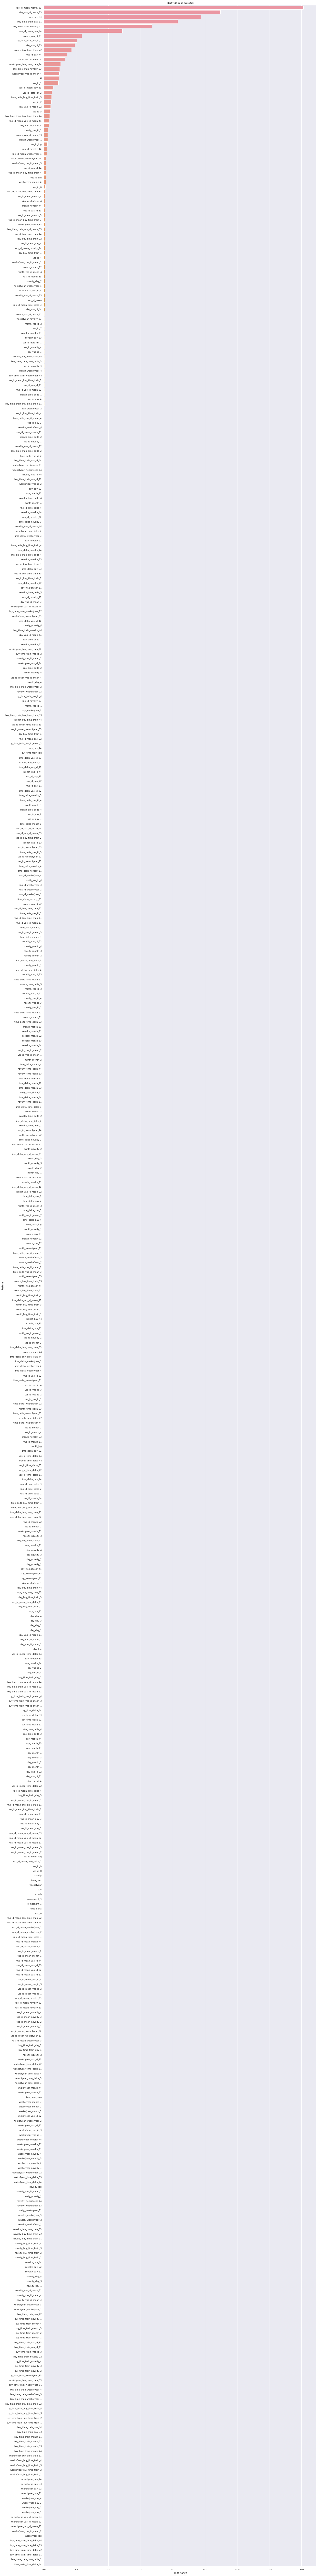

['vas_id_mean_month_33',
 'day_vas_id_mean_33',
 'day_day_33',
 'buy_time_train_day_11',
 'buy_time_train_novelty_11',
 'vas_id_mean_day_44',
 'month_vas_id_11',
 'buy_time_train_vas_id_1',
 'day_vas_id_33',
 'month_buy_time_train_22',
 'vas_id_day_44',
 'vas_id_vas_id_mean_4',
 'weekofyear_buy_time_train_44',
 'buy_time_train_novelty_33',
 'weekofyear_vas_id_mean_4',
 'id',
 'vas_id_1',
 'vas_id_mean_day_33',
 'vas_id_date_dif_2',
 'time_delta_buy_time_train_3',
 'vas_id_2',
 'day_vas_id_mean_22',
 'vas_id_5',
 'buy_time_train_buy_time_train_44',
 'vas_id_mean_vas_id_mean_44',
 'day_vas_id_mean_4',
 'novelty_vas_id_1',
 'month_vas_id_mean_33',
 'month_weekofyear_1',
 'vas_id_log']

In [174]:
show_feature_importances(feature_importances['feature_name'], feature_importances['importance'],\
                         get_top = 30)

SHAP показал 5 высоковажных фичей, качественно разделяющих датасет. Без экспансии таких было 2.

In [ ]:
#shap.summary_plot(shap_values, X_train, plot_type="bar")

Радует что предсказания важности фичей SHAP и самой модели близки.

In [185]:
feature_importances.loc[feature_importances['importance']>0]['feature_name'].tolist()

['id',
 'vas_id_1',
 'vas_id_2',
 'vas_id_4',
 'vas_id_5',
 'vas_id_6',
 'vas_id_7',
 'vas_id_ord',
 'vas_id_date_dif_1',
 'vas_id_date_dif_2',
 'vas_id_mean',
 'vas_id_mean_vas_id_mean_4',
 'vas_id_mean_vas_id_mean_44',
 'vas_id_mean_day_4',
 'vas_id_mean_day_22',
 'vas_id_mean_day_33',
 'vas_id_mean_day_44',
 'vas_id_mean_buy_time_train_1',
 'vas_id_mean_buy_time_train_3',
 'vas_id_mean_buy_time_train_4',
 'vas_id_mean_buy_time_train_33',
 'vas_id_mean_weekofyear_4',
 'vas_id_mean_weekofyear_33',
 'vas_id_mean_weekofyear_44',
 'vas_id_mean_novelty_44',
 'vas_id_mean_month_3',
 'vas_id_mean_month_4',
 'vas_id_mean_month_22',
 'vas_id_mean_month_33',
 'vas_id_mean_time_delta_3',
 'vas_id_mean_time_delta_33',
 'day_vas_id_mean_3',
 'day_vas_id_mean_4',
 'day_vas_id_mean_22',
 'day_vas_id_mean_33',
 'day_vas_id_mean_44',
 'day_day_22',
 'day_day_33',
 'day_day_44',
 'day_buy_time_train_1',
 'day_buy_time_train_4',
 'day_buy_time_train_22',
 'day_weekofyear_2',
 'day_weekofyear_3',
 'day_

In [186]:
# фичи, выбранные моделью feature_importances.loc[feature_importances['importance']>0]['feature_name'].tolist()
selected_feats = ['id','vas_id_1','vas_id_2','vas_id_4','vas_id_5','vas_id_6','vas_id_7','vas_id_ord','vas_id_date_dif_1','vas_id_date_dif_2',
   'vas_id_mean','vas_id_mean_vas_id_mean_4','vas_id_mean_vas_id_mean_44','vas_id_mean_day_4','vas_id_mean_day_22',
   'vas_id_mean_day_33','vas_id_mean_day_44','vas_id_mean_buy_time_train_1','vas_id_mean_buy_time_train_3','vas_id_mean_buy_time_train_4',
   'vas_id_mean_buy_time_train_33','vas_id_mean_weekofyear_4','vas_id_mean_weekofyear_33','vas_id_mean_weekofyear_44','vas_id_mean_novelty_44',
   'vas_id_mean_month_3','vas_id_mean_month_4','vas_id_mean_month_22','vas_id_mean_month_33','vas_id_mean_time_delta_3','vas_id_mean_time_delta_33',
   'day_vas_id_mean_3','day_vas_id_mean_4','day_vas_id_mean_22','day_vas_id_mean_33','day_vas_id_mean_44','day_day_22','day_day_33',
   'day_day_44','day_buy_time_train_1','day_buy_time_train_4','day_buy_time_train_22','day_weekofyear_2','day_weekofyear_3',
   'day_weekofyear_4','day_weekofyear_11','day_novelty_22','day_vas_id_1','day_vas_id_33','day_vas_id_44','day_month_22','day_time_delta_1',
   'day_time_delta_2','buy_time_train_log','buy_time_train_vas_id_mean_2','buy_time_train_vas_id_mean_33','buy_time_train_day_11',
   'buy_time_train_buy_time_train_11','buy_time_train_buy_time_train_33','buy_time_train_buy_time_train_44','buy_time_train_weekofyear_2',
   'buy_time_train_weekofyear_22','buy_time_train_weekofyear_44','buy_time_train_novelty_11','buy_time_train_novelty_33',
   'buy_time_train_novelty_44','buy_time_train_vas_id_1','buy_time_train_vas_id_2','buy_time_train_vas_id_4','buy_time_train_vas_id_22',
   'buy_time_train_vas_id_44','buy_time_train_time_delta_2','buy_time_train_time_delta_3','buy_time_train_time_delta_4','weekofyear_vas_id_mean_1',
   'weekofyear_vas_id_mean_3','weekofyear_vas_id_mean_4','weekofyear_vas_id_mean_44','weekofyear_buy_time_train_22','weekofyear_buy_time_train_44',
   'weekofyear_weekofyear_4','weekofyear_weekofyear_11','weekofyear_weekofyear_33','weekofyear_weekofyear_44','weekofyear_novelty_33',
   'weekofyear_vas_id_2','weekofyear_vas_id_4','weekofyear_vas_id_44','weekofyear_month_4','weekofyear_month_33','weekofyear_time_delta_2',
   'novelty_vas_id_mean_2','novelty_vas_id_mean_22','novelty_vas_id_mean_33','novelty_vas_id_mean_44','novelty_day_2','novelty_day_33',
   'novelty_buy_time_train_44','novelty_weekofyear_4','novelty_weekofyear_22','novelty_novelty_4','novelty_novelty_11','novelty_novelty_22',
   'novelty_novelty_33','novelty_novelty_44','novelty_vas_id_1','novelty_vas_id_44','novelty_time_delta_3','novelty_time_delta_4',
   'vas_id_log','vas_id_vas_id_mean_4','vas_id_vas_id_mean_22','vas_id_day_3','vas_id_day_4','vas_id_day_44','vas_id_buy_time_train_1',
   'vas_id_buy_time_train_3','vas_id_buy_time_train_4','vas_id_buy_time_train_33','vas_id_buy_time_train_44','vas_id_novelty_1',
   'vas_id_novelty_3','vas_id_novelty_4','vas_id_novelty_11','vas_id_novelty_22','vas_id_novelty_33','vas_id_novelty_44','vas_id_vas_id_11',
   'vas_id_vas_id_33','vas_id_vas_id_44','vas_id_month_33','vas_id_time_delta_4','month_vas_id_mean_4','month_vas_id_mean_11',
   'month_vas_id_mean_33','month_day_4','month_buy_time_train_22','month_buy_time_train_44','month_weekofyear_1','month_weekofyear_4',
   'month_novelty_4','month_novelty_44','month_vas_id_1','month_vas_id_2','month_vas_id_11','month_month_4','month_month_22','month_time_delta_1',
   'month_time_delta_2','time_delta_vas_id_mean_4','time_delta_day_33','time_delta_buy_time_train_3','time_delta_buy_time_train_4',
   'time_delta_weekofyear_3','time_delta_novelty_1','time_delta_novelty_22','time_delta_novelty_44','time_delta_vas_id_2','time_delta_vas_id_44']

In [187]:
# добавил в наиболее фичи фичи логирования
log_feats = ['target', 'id', 'vas_id', 'vas_id_1', 'vas_id_2', 'vas_id_4', 'vas_id_5', 'vas_id_6',
 'vas_id_7', 'vas_id_8', 'vas_id_9', 'vas_id_ord', 'vas_id_date_dif_1', 'vas_id_date_dif_2']

In [188]:
all_feats = list(set(log_feats).union(set(selected_feats)))

In [189]:
for_pca_feats = list(set(all_feats) - set(log_feats))
len(for_pca_feats)

149

In [190]:
set(log_feats).intersection(set(for_pca_feats))

set()

In [191]:
set(log_feats).union(set(for_pca_feats)) - set(all_feats)

set()

In [192]:
set(all_feats) - set(log_feats).union(set(for_pca_feats))

set()

In [193]:
class For_pca_2:

    def __init__(self, log_feats):
        self.log_feats = log_feats
        self.scaler = None
        self.corr_feats = None
        self.not_corr_feats = log_feats
        self.dim_reducer3d = None


    def convert_to_int(self, df):
        df[self.log_feats] = df[self.log_feats].astype('int8')
        return df

    def my_scaler_fit(self, df):
        """Обучаю RobustScaler для стандартизации нумерованных фичей для   упаковки в  PCA"""
        from sklearn.preprocessing import RobustScaler
        self.scaler = RobustScaler()
        self.scaler.fit(df[self.corr_feats])
    
        #return self.scaler

    def my_scaler_transform(self, df):
        """Преобразую RobustScaler_ом нумерованные фичи для упаковки в  PCA и показываю корреляцию этих фичей"""
        df_norm = self.scaler.fit_transform(df[self.corr_feats])
    
        plt.figure(figsize = (15,10))
        sns.set(font_scale=1.4)
        corr_matrix = pd.DataFrame(df_norm).corr()
        corr_matrix = np.round(corr_matrix, 2)  # округлим до 2 знаков
        corr_matrix[np.abs(corr_matrix) < 0.5] = 0  # если корреляция меньше 0,5, то мы заменим на 0
        sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
        plt.title('Correlation matrix')
        plt.show()
    
        df_1 = df[self.not_corr_feats]
        df_1 = df_1.reset_index(drop=True)
        df_norm = pd.DataFrame(df_norm, columns = self.corr_feats)
        df_scaled=pd.concat([df_1, df_norm], axis=1)
    
        return df_scaled

    def reduce_dims(self, df, dims=2, method='pca', perplexity=30):
    
        assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
        if method=='pca':
            from sklearn.decomposition import PCA
            dim_reducer = PCA(n_components=dims, random_state=42)
            components = dim_reducer.fit_transform(df)
        elif method == 'tsne':
            dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42, perplexity=perplexity)
            components = dim_reducer.fit_transform(df)
        else:
            print('Error')
        
        colnames = ['component_' + str(i) for i in range(1, dims+1)]
        return dim_reducer, pd.DataFrame(data = components, columns = colnames) 

    def pca_fit_transform(self, train):
        """Функция сжимающая малозначимые признаки методом PCA и возвращающая кроме 
        обработанного датасета натренированную модель PCA"""
        self.dim_reducer3d, components_3d = self.reduce_dims(train[self.corr_feats], 
                                                             dims=3, method='pca')
        train_pca = pd.concat([train[self.not_corr_feats], components_3d], axis=1)
    
        return train_pca

    def pca_transform(self, test):
        """Функция сжимающая малозначимые признаки методом PCA на тестовой выборке"""
        dims = 3
        components = self.dim_reducer3d.transform(test[self.corr_feats])
        colnames = ['component_' + str(i) for i in range(1, dims+1)]
        components_3d_test = pd.DataFrame(data = components, columns = colnames)
        test_pca = pd.concat([test[self.not_corr_feats],
                              components_3d_test], axis=1)
    
        return test_pca


    def fit_transform(self, train):
        train = self.convert_to_int(train)
        all_feats = train.columns.tolist()
        self.corr_feats = [i for i in all_feats if i not in self.not_corr_feats]
        self.my_scaler_fit(train)
        train = self.my_scaler_transform(train)
        train_pca = self.pca_fit_transform(train)
        return train_pca

    def transform(self, test):
        test = self.convert_to_int(test)
        test = self.my_scaler_transform(test)
        test_pca = self.pca_transform(test)      
        return test_pca


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


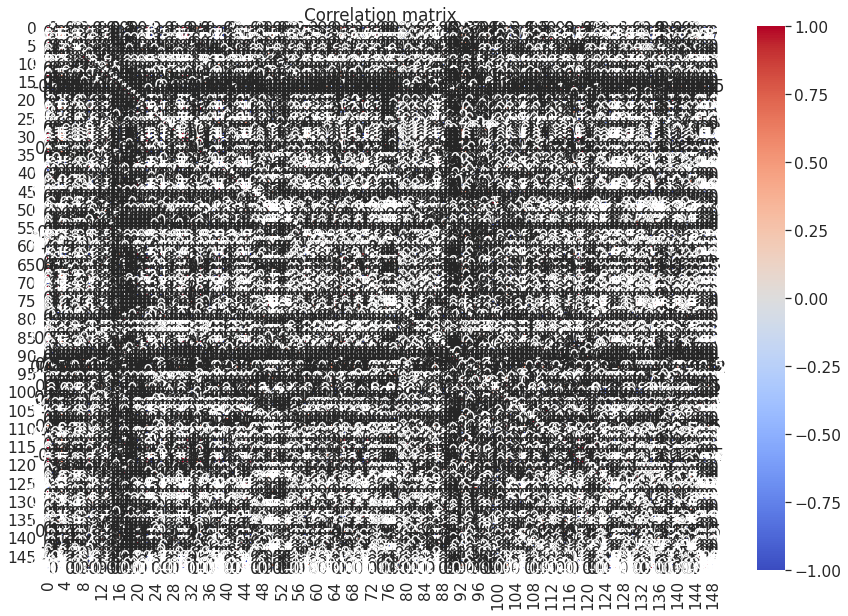


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


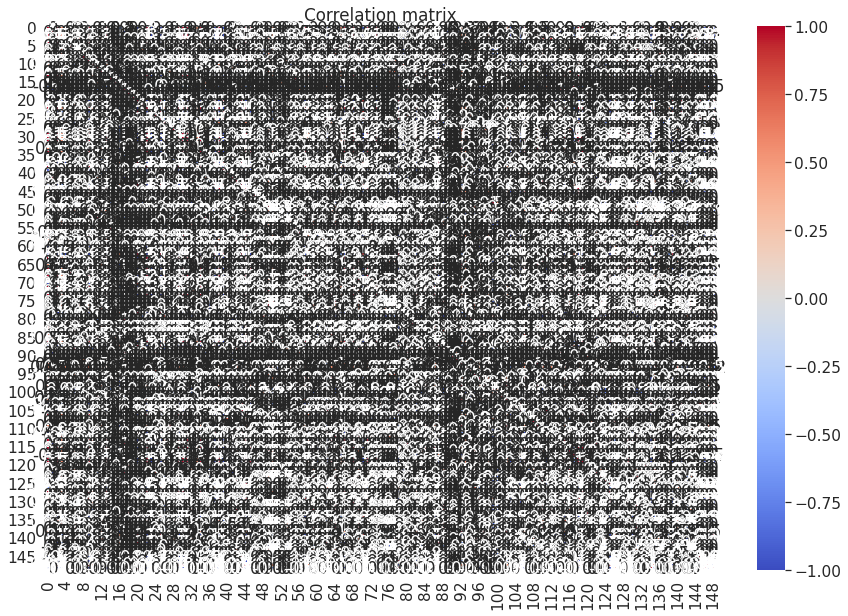

In [194]:
for_pca_2 = For_pca_2(log_feats)
train_pca = for_pca_2.fit_transform(train_exp[all_feats])
test_pca = for_pca_2.transform(test_exp[all_feats])

In [195]:
train_exp.columns

Index(['target', 'id', 'buy_time_train', 'vas_id', 'time_delta', 'component_1',
       'component_3', 'month', 'day', 'weekofyear',
       ...
       'time_delta_month_33', 'time_delta_month_44', 'time_delta_time_delta_1',
       'time_delta_time_delta_2', 'time_delta_time_delta_3',
       'time_delta_time_delta_4', 'time_delta_time_delta_11',
       'time_delta_time_delta_22', 'time_delta_time_delta_33',
       'time_delta_time_delta_44'],
      dtype='object', length=544)

In [196]:
train_pca

target   id  vas_id  vas_id_1  vas_id_2  vas_id_4  vas_id_5  vas_id_6  \
0            0 -118       4         0         0         0         0         0   
1            0  -28       1         0         0         0         0         0   
2            1  -23       6         0         0         0         0         0   
3            1 -108       6         0         0         0         0         0   
4            0  -13       1         0         0         0         0         0   
...        ...  ...     ...       ...       ...       ...       ...       ...   
286101       0   11       1         0         0         0         0         0   
286102       0 -127       5         0         0         0         0         0   
286103       0   85       4         0         0         0         0         0   
286104       0   72       1         0         0         0         0         0   
286105       0  -39       5         0         0         0         0         0   

        vas_id_7  vas_id_8  vas_id_9  vas_id_ord  vas_id_date_dif_1  \
0              0         0         0           0                  0   
1              0         0         0           0                  0   
2              0         0         0           0                  0   
3              0         0         0           0                  0   
4              0         0         0           0                  0   
...          ...       ...       ...         ...                ...   
286101         0         0         0           0                  0   
286102         0         0         0           0                  0   
286103         0         0         0           0                  0   
286104         0         0         0           0                  0   
286105         0         0         0           0                  0   

        vas_id_date_dif_2   component_1   component_2   component_3  
0                       0 -4.200012e+11 -2.066809e+11  6.166603e+09  
1                       0 -4.200012e+11 -2.066809e+11  6.166603e+09  
2                       0 -4.200012e+11 -2.066809e+11  6.166603e+09  
3                       0 -4.200012e+11 -2.066809e+11  6.166603e+09  
4                       0 -4.200012e+11 -2.066809e+11  6.166603e+09  
...                   ...           ...           ...           ...  
286101                  0 -4.200012e+11 -2.066809e+11  6.166603e+09  
286102                  0 -4.200012e+11 -2.066809e+11  6.166603e+09  
286103                  0  1.571308e+13 -1.631838e+11 -2.578369e+10  
286104                  0 -4.200012e+11 -2.066809e+11  6.166603e+09  
286105                  0 -4.200012e+11 -2.066809e+11  6.166603e+09  

[286106 rows x 17 columns]

In [197]:
feature_importances = choise_features(train_pca, test_pca, ['vas_id'])

0    0.90925
1    0.09075
Name: target, dtype: float64

0    0.909255
1    0.090745
Name: target, dtype: float64

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.85      0.92    260142
           1       0.37      0.88      0.53     25964

    accuracy                           0.86    286106
   macro avg       0.68      0.87      0.72    286106
weighted avg       0.93      0.86      0.88    286106

TEST

              precision    recall  f1-score   support

           0       0.98      0.86      0.91    111491
           1       0.37      0.83      0.51     11127

    accuracy                           0.86    122618
   macro avg       0.67      0.85      0.71    122618
weighted avg       0.93      0.86      0.88    122618

CONFUSION MATRIX

col_0       0      1
target              
0       95570  15921
1        1842   9285


In [200]:
feature_importances = choise_features(train, test, ['vas_id'])

0.0    0.90925
1.0    0.09075
Name: target, dtype: float64

0.0    0.909255
1.0    0.090745
Name: target, dtype: float64

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.86      0.92    260142
         1.0       0.40      0.96      0.56     25964

    accuracy                           0.86    286106
   macro avg       0.70      0.91      0.74    286106
weighted avg       0.94      0.86      0.89    286106

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    111491
         1.0       0.40      0.95      0.56     11127

    accuracy                           0.86    122618
   macro avg       0.70      0.90      0.74    122618
weighted avg       0.94      0.86      0.89    122618

CONFUSION MATRIX

col_0     0.0    1.0
target              
0.0     95446  16045
1.0       592  10535


Точность предсказания уменьшилась, поэтому этот шаг не имеет смысла.

In [23]:
choise_features(train.loc[train['vas_id']==6], test.loc[test['vas_id']==6], None)

0.0    0.562549
1.0    0.437451
Name: target, dtype: float64

0.0    0.569698
1.0    0.430302
Name: target, dtype: float64

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

         0.0       0.63      0.70      0.67     16571
         1.0       0.55      0.48      0.51     12886

    accuracy                           0.60     29457
   macro avg       0.59      0.59      0.59     29457
weighted avg       0.60      0.60      0.60     29457

TEST

              precision    recall  f1-score   support

         0.0       0.62      0.73      0.67      7242
         1.0       0.54      0.41      0.47      5470

    accuracy                           0.59     12712
   macro avg       0.58      0.57      0.57     12712
weighted avg       0.59      0.59      0.58     12712

CONFUSION MATRIX

col_0    0.0   1.0
target            
0.0     5288  1954
1.0     3212  2258


feature_name  importance
0                  id    2.094434
1      buy_time_train   12.749473
2              vas_id    0.000000
3          time_delta    1.536234
4         component_1    0.413614
5         component_3    0.952850
6               month    4.496139
7                 day    9.801914
8          weekofyear    5.742750
9            time_max    0.000000
10            how_old   14.745311
11            novelty    2.712238
12           vas_id_1    2.281759
13           vas_id_2    3.767309
14           vas_id_4    3.649522
15           vas_id_5    4.454473
16           vas_id_6   21.849164
17           vas_id_7    0.141967
18           vas_id_8    0.003105
19           vas_id_9    0.087006
20         vas_id_ord    2.527988
21  vas_id_date_dif_1    0.160786
22  vas_id_date_dif_2    5.831964
23        vas_id_mean    0.000000
24    log_vas_id_mean    0.000000

на vas_id==6 самое худшее предсказание.  Попробую улучшить его отдельной моделью.

In [198]:
if 0:
    train_pca.to_csv(data_folder.joinpath('train.csv'), index=False)
    test_pca.to_csv(data_folder.joinpath('test.csv'), index=False)

In [199]:
if 0:
    train_pca.to_csv('train.csv', index=False)
    test_pca.to_csv('test.csv', index=False)